# Creating the fine-tuning dataset for the MSA based on the pre-matched pre-training dataset

In [7]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
pd.options.display.max_columns = None

## Grabbing APOGEE

In [8]:
data = Table.read('sdss-apogee-dr17.fits')
names = [name for name in data.colnames if len(data[name].shape) <= 1]
data = data[names].to_pandas()
print('APOGEE loaded')

APOGEE loaded


In [11]:
data.GAIAEDR3_SOURCE_ID.value_counts()

GAIAEDR3_SOURCE_ID
0                      5565
1460648219080249728      18
1460672614494496384      18
1460684709121087232      17
1460685980432727808      17
                       ... 
3145218127256410240       1
934261768926384640        1
673713350351874816        1
5273890333894734080       1
2772098031734496512       1
Name: count, Length: 651625, dtype: int64

In [12]:
# removing the duplicated sources and the sources without gaia ids because it will cause issues while finetuning 
# potentially could re add them with the full trained model through a wise, 2mass, or other photometric catalogue xmatch
data = data[~data.duplicated(subset='GAIAEDR3_SOURCE_ID', keep=False)]
data.GAIAEDR3_SOURCE_ID.value_counts()

GAIAEDR3_SOURCE_ID
538028216707715712     1
1632292120300078976    1
1352085533328736384    1
4125972741086408960    1
1635662089078813952    1
                      ..
5274939749024383616    1
3137132662344118016    1
865264356267099648     1
892278704126034688     1
2772098031734496512    1
Name: count, Length: 591499, dtype: int64

In [13]:
data

FILE              APOGEE_ID  \
1       b'apStar-dr17-2M00000002+7417074.fits'  b'2M00000002+7417074'   
2       b'apStar-dr17-2M00000019-1924498.fits'  b'2M00000019-1924498'   
5       b'asStar-dr17-2M00000035-7323394.fits'  b'2M00000035-7323394'   
6       b'apStar-dr17-2M00000068+5710233.fits'  b'2M00000068+5710233'   
7       b'apStar-dr17-2M00000103+1525513.fits'  b'2M00000103+1525513'   
...                                        ...                    ...   
733896  b'apStar-dr17-2M23595886-2009435.fits'  b'2M23595886-2009435'   
733897  b'apStar-dr17-2M23595886+5726058.fits'  b'2M23595886+5726058'   
733898  b'apStar-dr17-2M23595921+5609479.fits'  b'2M23595921+5609479'   
733899  b'asStar-dr17-2M23595949-7342592.fits'  b'2M23595949-7342592'   
733900  b'apStar-dr17-2M23595980+1528407.fits'  b'2M23595980+1528407'   

                                       TARGET_ID  \
1            b'apo25m.120+12.2M00000002+7417074'   
2            b'apo25m.060-75.2M00000019-1924498'   
5             b'lco25m.SMC12.2M00000035-7323394'   
6             b'apo25m.N7789.2M00000068+5710233'   
7        b'apo25m.107-46_MGA.2M00000103+1525513'   
...                                          ...   
733896       b'apo25m.060-75.2M23595886-2009435'   
733897       b'apo25m.116-04.2M23595886+5726058'   
733898  b'apo25m.NGC7789_MGA.2M23595921+5609479'   
733899        b'lco25m.SMC12.2M23595949-7342592'   
733900       b'apo25m.105-45.2M23595980+1528407'   

                                                APSTAR_ID  \
1        b'apogee.apo25m.stars.120+12.2M00000002+7417074'   
2        b'apogee.apo25m.stars.060-75.2M00000019-1924498'   
5         b'apogee.lco25m.stars.SMC12.2M00000035-7323394'   
6         b'apogee.apo25m.stars.N7789.2M00000068+5710233'   
7       b'apogee.apo25m.stars.107-46_MGA.2M00000103+15...   
...                                                   ...   
733896   b'apogee.apo25m.stars.060-75.2M23595886-2009435'   
733897   b'apogee.apo25m.stars.116-04.2M23595886+5726058'   
733898  b'apogee.apo25m.stars.NGC7789_MGA.2M23595921+5...   
733899    b'apogee.lco25m.stars.SMC12.2M23595949-7342592'   
733900   b'apogee.apo25m.stars.105-45.2M23595980+1528407'   

                                                ASPCAP_ID  TELESCOPE  \
1       b'apogee.apo25m.synspec_fix.120+12.2M00000002+...  b'apo25m'   
2       b'apogee.apo25m.synspec_fix.060-75.2M00000019-...  b'apo25m'   
5       b'apogee.lco25m.synspec_fix.SMC12.2M00000035-7...  b'lco25m'   
6       b'apogee.apo25m.synspec_fix.N7789.2M00000068+5...  b'apo25m'   
7       b'apogee.apo25m.synspec_fix.107-46_MGA.2M00000...  b'apo25m'   
...                                                   ...        ...   
733896  b'apogee.apo25m.synspec_fix.060-75.2M23595886-...  b'apo25m'   
733897  b'apogee.apo25m.synspec_fix.116-04.2M23595886+...  b'apo25m'   
733898  b'apogee.apo25m.synspec_fix.NGC7789_MGA.2M2359...  b'apo25m'   
733899  b'apogee.lco25m.synspec_fix.SMC12.2M23595949-7...  b'lco25m'   
733900  b'apogee.apo25m.synspec_fix.105-45.2M23595980+...  b'apo25m'   

        LOCATION_ID           FIELD   ALT_ID          RA        DEC  \
1              5046       b'120+12'  b'none'    0.000103  74.285408   
2              5071       b'060-75'  b'none'    0.000832 -19.413851   
5              7218        b'SMC12'  b'none'    0.001467 -73.394287   
6              4264        b'N7789'  b'none'    0.002850  57.173164   
7              2897   b'107-46_MGA'  b'none'    0.004322  15.430942   
...             ...             ...      ...         ...        ...   
733896         5071       b'060-75'  b'none'  359.995258 -20.162107   
733897         4424       b'116-04'  b'none'  359.995265  57.434956   
733898         -999  b'NGC7789_MGA'  b'none'  359.996744  56.163330   
733899         7218        b'SMC12'  b'none'  359.997887 -73.716454   
733900         4548       b'105-45'  b'none'  359.999181  15.477974   

              GLON       GLAT       J  J_ERR       H  H_ERR       K  K_ERR  \
1       119

### Adding astroNN ages

In [14]:
astronn2 = pd.read_csv('nn_latent_age_dr17.csv.gz', compression='gzip')

In [15]:
astronn2 = astronn2.dropna()
astronn2 = astronn2[(astronn2['Age_Error']/astronn2['Age'] < 0.4) & (astronn2['STARFLAG'] == 0) & (astronn2['ASPCAPFLAG'] == 0)]

no STARFLAG and ASPCAPFLAG flag set as well as requiring a latent space age uncertainty less than 40% from Leung2023+

In [16]:
astronn1 = Table.read('apogee_astroNN-DR17.fits').to_pandas()

In [17]:
astronn1['APOGEE_ID'] = [val.decode("utf-8") for val in astronn1['APOGEE_ID'].values]

In [18]:
astronn2 = astronn2.drop_duplicates(subset='APOGEE_ID')
astronn1 = astronn1.drop_duplicates(subset='APOGEE_ID')

In [19]:
astronn1 = astronn1[~astronn1['APOGEE_ID'].isin(astronn2['APOGEE_ID'])]

In [20]:
astronn2

APOGEE_ID TELESCOPE        FIELD  STARFLAG  ASPCAPFLAG  \
6       2M00000068+5710233    apo25m        N7789         0         0.0   
28      2M00000866+7122144    apo25m       120+08         0         0.0   
30      2M00000943+6254542    apo25m       116+00         0         0.0   
33      2M00001104+6348085    apo25m       117+01         0         0.0   
41      2M00001296+5851378    apo25m       116-04         0         0.0   
...                    ...       ...          ...       ...         ...   
733844  2M23594733+5640020    apo25m  NGC7789_btx         0         0.0   
733852  2M23594841+5653269    apo25m  NGC7789_MGA         0         0.0   
733871  2M23595371+8506304    apo25m   NGC188_btx         0         0.0   
733875  2M23595481+7509560    apo25m       120+12         0         0.0   
733877  2M23595490+5704387    apo25m        N7789         0         0.0   

              z0        z1        z2        z3        z4       Age  Age_Error  \
6       0.109831  2.783816  0.490213  0.129695  0.558129  3.713866   1.315107   
28     -0.218892 -0.210707  0.335599  0.026745 -0.049675  6.893998   2.467813   
30      1.070844  0.019565 -0.612649  0.131504  1.010401  5.862042   1.648183   
33     -0.392587  2.486913  0.324700 -0.059272  0.348974  4.089180   1.374299   
41     -0.864830  0.355200 -0.505398  0.214336  0.278643  6.304886   2.076918   
...          ...       ...       ...       ...       ...       ...        ...   
733844 -0.387422  1.216002  0.015684 -0.532662  0.586736  3.322011   0.391614   
733852 -0.052397 -0.401596  0.844707  0.071187  0.393542  7.658290   2.758648   
733871  0.069476  2.301538 -0.021433 -0.355563  0.002955  2.848126   0.609402   
733875  0.481890  0.615120  0.276652  0.426074 -0.893327  6.429371   2.465394   
733877 -0.068986  1.161586 -0.744653 -0.896519  0.699384  0.822008   0.116917   

          LogAge  LogAge_Error  
6       0.569826      0.138561  
28      0.838471      0.145866  
30      0.768049      0.134069  
33      0.611636      0.135857  
41      0.799677      0.164960  
...          ...           ...  
733844  0.521401      0.057360  
733852  0.884132      0.165442  
733871  0.454559      0.114833  
733875  0.808168      0.182784  
733877 -0.085124      0.061572  

[48835 rows x 14 columns]

In [21]:
astronn = pd.concat([astronn1, astronn2])

In [22]:
astronn

APOGEE_ID  LOCATION_ID  TELESCOPE  RA_APOGEE  DEC_APOGEE  \
0                    VESTA          1.0   b'apo1m'        NaN         NaN   
1       2M00000002+7417074       5046.0  b'apo25m'   0.000103   74.285408   
2       2M00000019-1924498       5071.0  b'apo25m'   0.000832  -19.413851   
3       2M00000032+5737103       4424.0  b'apo25m'   0.001335   57.619530   
5       2M00000035-7323394       7218.0  b'lco25m'   0.001467  -73.394287   
...                    ...          ...        ...        ...         ...   
733844  2M23594733+5640020          NaN     apo25m        NaN         NaN   
733852  2M23594841+5653269          NaN     apo25m        NaN         NaN   
733871  2M23595371+8506304          NaN     apo25m        NaN         NaN   
733875  2M23595481+7509560          NaN     apo25m        NaN         NaN   
733877  2M23595490+5704387          NaN     apo25m        NaN         NaN   

               TEFF    TEFF_ERR      LOGG  LOGG_ERR       C_H   C_H_ERR  \
0               NaN         NaN       NaN       NaN       NaN       NaN   
1       3730.434814   49.411095  0.864455  0.091876 -0.151543  0.032733   
2       5517.530273  136.336548  4.045386  0.218193 -0.239434  0.041846   
3       6120.589355  157.397263  3.726100  0.178082 -0.199688  0.034659   
5       4473.471191  151.328293  1.654428  0.448441 -1.750013  0.298410   
...             ...         ...       ...       ...       ...       ...   
733844          NaN         NaN       NaN       NaN       NaN       NaN   
733852          NaN         NaN       NaN       NaN       NaN       NaN   
733871          NaN         NaN       NaN       NaN       NaN       NaN   
733875          NaN         NaN       NaN       NaN       NaN       NaN   
733877          NaN         NaN       NaN       NaN       NaN       NaN   

            CI_H  CI_H_ERR       N_H   N_H_ERR       O_H   O_H_ERR      NA_H  \
0            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1      -0.190584  0.048255  0.001321  0.031254 -0.058263  0.043236 -0.101348   
2      -0.180557  0.050743 -0.196976  0.107710 -0.058122  0.064277 -0.332414   
3      -0.213643  0.087808  0.055638  0.237938 -0.121718  0.069642 -0.401479   
5      -2.109162  0.532066 -1.166456  0.226323 -1.277044  0.255523 -1.596640   
...          ...       ...       ...       ...       ...       ...       ...   
733844       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
733852       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
733871       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
733875       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
733877       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        NA_H_ERR      MG_H  MG_H_ERR      AL_H  AL_H_ERR      SI_H  SI_H_ERR  \
0            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       0.051404 -0.100000  0.035004 -0.244900  0.063405 -0.176255  0.033154   
2       0.315590 -0.118756  0.045523 -0.038950  0.085769 -0.129614  0.061684   
3       0.491485 -0.259117  0.059413 -0.173805  0.114187 -0.111757  0.063613   
5       0.493505 -1.336941  0.215491 -1.862636  0.355184 -1.419353  0.211469   
...          ...       ...       ...       ...       ...       ...       ...   
733844       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
733852       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
733871       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
733875       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
733877       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

             P_H   P_H_ERR       S_H   S_H_ERR       K_H   K_H_ERR      CA_H  \
0            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1      -0.123234  0.637760 -0.105699  0.058216 -0.069167  0.068020 -0.203713   
2       0.011365  1.358047 -0

In [24]:
data['APOGEE_ID'] = [val.decode("utf-8") for val in data['APOGEE_ID'].values]

In [25]:
data = pd.merge(data, astronn, how='left', on='APOGEE_ID')

In [26]:
data.describe()

/opt/conda/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


LOCATION_ID_x           RA_x          DEC_x           GLON  \
count  591499.000000  591499.000000  591499.000000  591499.000000   
mean     4802.043388     182.044781       5.059273     163.190963   
std      1410.013812      99.006153      40.205781     103.489529   
min      -999.000000       0.000103     -87.224808       0.000088   
25%      4291.000000      92.617720     -24.283006      75.131894   
50%      5154.000000     184.772545       7.844993     160.793295   
75%      5708.000000     270.730192      39.256425     254.950894   
max      7254.000000     359.999181      87.608246     359.999832   

                GLAT              J          J_ERR              H  \
count  591499.000000  585319.000000  584722.000000  591496.000000   
mean        5.074378      11.666391       0.024805      10.907277   
std        33.117667       4.086236       0.032877       1.629516   
min       -89.909116       5.180000       0.000000       0.358000   
25%       -13.930892      10.561000       0.022000      10.012000   
50%         1.527225      11.556000       0.023000      10.961000   
75%        26.815624      12.567000       0.026000      11.922000   
max        89.931476      99.999001       9.998000      99.999001   

               H_ERR              K          K_ERR        WASH_M  \
count  584270.000000  585312.000000  583861.000000  51983.000000   
mean        0.026477      10.872186       0.024059      8.449368   
std         0.043835       4.098649       0.078900      7.024658   
min         0.000000       4.382000       0.000000      0.000000   
25%         0.022000       9.832000       0.019000      0.000000   
50%         0.024000      10.798000       0.022000     12.106365   
75%         0.028000      11.709000       0.025000     14.484791   
max         9.999000      99.999001       9.998000     79.274292   

         WASH_M_ERR       WASH_T2   WASH_T2_ERR         DDO51     DDO51_ERR  \
count  51985.000000  51985.000000  51985.000000  51985.000000  51985.000000   
mean       0.008741      7.629732      0.016345      8.479998      0.007552   
std        0.013077      6.329545      0.022333      7.038235      0.011749   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.008000     10.962000      0.014686     12.140693      0.006966   
75%        0.012393     13.153336      0.024000     14.539000      0.011000   
max        0.730000     18.593000      0.856000     22.937000      0.682000   

           IRAC_3_6  IRAC_3_6_ERR      IRAC_4_5  IRAC_4_5_ERR      IRAC_5_8  \
count  50993.000000  50993.000000  51604.000000  51604.000000  38239.000000   
mean      10.336399      0.405934     10.128586      0.134551     10.011348   
std        5.782339      6.009540      3.316522      2.917080      4.250849   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        9.190000      0.034000      9.263755      0.032257      9.145704   
50%       10.364000      0.041000     10.402116      0.048000     10.287000   
75%       11.366835      0.049409     11.373321      0.061955     11.243590   
max       99.999001     99.999001     99.999001     99.999001     99.999001   

       IRAC_5_8_ERR      IRAC_8_0  IRAC_8_0_ERR       WISE_4_5   WISE_4_5_ERR  \
count  38239.000000  37915.000000  37915.000000  565786.000000  565752.000000   
mean       0.222109     10.234992      0.524505      10.613866       0.022614   
std        4.053467      6.556503      6.851477       1.509329       0.008532   
min        0.000000      0.000000      0.000000      -1.897000       0.000000   
25%        0.035847      9.099000      0.029788       9.753000       0.020000   
50%        0.050394     10.238957      0.043000      10.734000       0.021000   
75%        0.073488     11.218040      0.066730      11.606000       0.022000   
max       99.999001     99.999001     99.999001      18.236000       0.517000 

In [27]:
data.GAIAEDR3_SOURCE_ID.dtypes

dtype('int64')

In [35]:
ft_table[~np.isnan(data['Age'])].dropna(subset='bp_1')

source_id         teff     e_teff      logg    e_logg  \
3        421077597267551104  5031.263672  10.145057  3.456132  0.023554   
21       531274466534134272  4669.081055   7.625217  2.527280  0.022586   
23       430055732493885056  4644.806152  11.155644  2.602583  0.028489   
26       431606593645003648  4911.428223  11.992949  3.099539  0.026685   
32       422775144446526080  4687.809082   9.489824  2.738336  0.025003   
...                     ...          ...        ...       ...       ...   
591450  1995001867937979904  4914.148438  14.470281  2.872979  0.032230   
591456  1995019735002059520  4660.646484   7.747389  2.544573  0.023535   
591471  2300137613314914560  5092.243164  12.708504  3.379881  0.026450   
591475  2229276008757698944  4824.351562   9.166178  2.718271  0.025805   
591477  1995072339763340928  5015.407715   9.502117  2.892750  0.021294   

            fe_h    e_fe_h     alpha   e_alpha       age     e_age      W1  \
3      -0.160080  0.006013  0.055704  0.006063  3.713866  1.315107   9.992   
21     -0.124120  0.006263  0.021539  0.005498  6.893998  2.467813   8.749   
23      0.018956  0.008830  0.050769  0.007255  5.862042  1.648183  12.041   
26     -0.002820  0.007544  0.006806  0.006887  4.089180  1.374299  11.657   
32      0.017087  0.007339  0.055015  0.006168  6.304886  2.076918  11.270   
...          ...       ...       ...       ...       ...       ...     ...   
591450 -0.214190  0.009302  0.051529  0.009007  3.322011  0.391614  12.458   
591456 -0.216040  0.006511  0.064513  0.005857  7.658290  2.758648   8.139   
591471 -0.120110  0.006967  0.049859  0.007046  2.848126  0.609402  11.782   
591475 -0.393200  0.006828  0.100126  0.006858  6.429371  2.465394   9.281   
591477  0.059443  0.005509 -0.023785  0.005176  0.822008  0.116917   8.565   

            W2          G         BP         RP           bp_1          bp_2  \
3       10.042  12.275905  12.831100  11.569275  440427.750879 -12879.553124   
21       8.816  12.186060  13.164437  11.214675  329225.111946  52356.068692   
23      12.228  15.927272  16.983782  14.908782  308098.276337  55862.781788   
26      11.712  14.787058  15.629883  13.885020  362518.308635  35941.515020   
32      11.392  14.990187  16.018772  13.992433  317127.329078  56805.466317   
...        ...        ...        ...        ...            ...           ...   
591450  12.572  15.348444  16.065422  14.518527  395744.201891  18886.982448   
591456   8.463  11.175990  11.847914  10.384642  412085.949840  14709.859114   
591471  11.836  14.192754  14.813242  13.438663  423322.309995   2531.319668   
591475   9.331  12.202727  12.984946  11.337752  378533.407652  30762.145892   
591477   8.627  11.023248  11.640724  10.268590  425343.369552   4946.073268   

                bp_3         bp_4         bp_5         bp_6         bp_7  \
3      -15665.474147  3100.726500 -3076.004889  1008.572770 -2345.479039   
21     -15053.848398 -6082.781266 -3259.651756  5029.003428  -662.755195   
23     -12830.172356 -6325.081929 -2269.101858  4222.123991   491.825178   
26     -17381.402881 -2721.371178 -3900.129439  5004.791261  -191.934481   
32     -14266.706133 -7971.998785 -2464.950818  4802.301074  -157.391582   
...              ...          ...          ...          ...          ...   
591450 -17399.202782 -1061.721231 -4820.716015  2550.561979 -1036.758168   
591456 -19538.472648  1958.307759 -3242.008063  1766.004027 -1409.335673   
591471 -18004.811672  4403.794023 -4360.439952  2280.559770 -1427.005425   
591475 -17301.339862 -1138.462796 -3468.821826  4704.240918  -776.496241   
591477 -18439.951031  3661.815864 -4665.107969  1955.972589 -1556.670057   

               bp_8        bp_9       bp_10       bp_11       bp_12  \
3       -411.838574  -87.308848  137.577274   14.767591   57.491103   
21      -603.596226  249.400718  659.428633  234.431995  333.692878   
23       347.240124   87.016658  663.937997  279.868804 -193.426125   
26     -1207.665343 -2

Having that low data is frustrating

In [23]:
cols_to_keep = ['GAIAEDR3_SOURCE_ID','TEFF_x','TEFF_ERR_x','LOGG_x','LOGG_ERR_x','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','Age','Age_Error','age','age_total_error']
renamed_cols = ['gaiadr3_source_id','teff','e_teff','logg','e_logg','fe_h','e_fe_h','alpha','e_alpha','age','e_age']

In [24]:
data = data[cols_to_keep]

In [28]:
data['total_age'] = np.nanmax([data['age'],data['Age']], axis=0)

/tmp/ipykernel_9828/3757849999.py:1: RuntimeWarning: All-NaN axis encountered
  data['total_age'] = np.nanmax([data['age'],data['Age']], axis=0)


In [30]:
data['total_age_error'] = np.nanmax([data['age_total_error'],data['Age_Error']], axis=0)

/tmp/ipykernel_9828/3110513876.py:1: RuntimeWarning: All-NaN axis encountered
  data['total_age_error'] = np.nanmax([data['age_total_error'],data['Age_Error']], axis=0)


In [ ]:
cols_to_keep = cols_to_keep[:-4] + ['total_age','total_age_error']

In [33]:
data = data.drop(columns=['Age','Age_Error','age','age_total_error'])

In [34]:
namedict = {}
for col, newname in zip(cols_to_keep,renamed_cols):
    namedict[col] = newname
data = data.rename(columns=namedict)

In [35]:
data

gaiadr3_source_id         teff     e_teff      logg    e_logg  \
0        538028216707715712  3723.911133   4.060303  0.904598  0.021523   
1       2413929812587459072  5501.772949  25.553564  4.304115  0.024555   
2       4689447878791422208  4555.404297  21.238880  1.498851  0.082635   
3        421077597267551104  5031.263672  10.145057  3.456132  0.023554   
4       2772097619417608704  5945.750977  44.246799  4.123192  0.033373   
...                     ...          ...        ...       ...       ...   
591494  2341765776376373376          NaN        NaN       NaN       NaN   
591495  1998097371124974720  4859.908691   9.050734  2.480687  0.024013   
591496  1994741318040223232  4585.409668  11.298859  2.571437  0.028686   
591497  6379914575198998272  4509.591309  18.433924  1.334888  0.077052   
591498  2772098031734496512  6281.626953  59.489235  3.972290  0.038770   

           fe_h    e_fe_h     alpha   e_alpha       age     e_age  
0      -0.14768  0.007183  0.036922  0.004735  6.308862  3.875223  
1      -0.26875  0.006753  0.090978  0.007373  7.416848  1.930535  
2      -1.18320  0.019806  0.008442  0.025910  4.159448  2.494765  
3      -0.16008  0.006013  0.055704  0.006063  3.713866  1.315107  
4      -0.26704  0.008147  0.012409  0.012326  5.056322  2.531886  
...         ...       ...       ...       ...       ...       ...  
591494      NaN       NaN       NaN       NaN  4.656937  2.236992  
591495 -0.22925  0.006350  0.065434  0.006152  1.945970  0.720498  
591496  0.11992  0.009225  0.037709  0.007182  2.361398  0.763392  
591497 -1.04180  0.018825 -0.019310  0.023462  9.151896  0.968808  
591498 -0.67222  0.008434  0.238005  0.014992  6.637845  3.325536  

[591499 rows x 11 columns]

In [37]:
gaiadata = []
with h5py.File('220M_pretrain_data.h5','r') as f:
    progress_bar = tqdm(f.keys(),total=len(f.keys()))
    for key in progress_bar:
        mask = np.isin(f[key][:]['source_id'], data['gaiadr3_source_id'])
        gaiadata.extend([list(tup) for tup in f[key][:][mask]])
    dtypes = f['sslset0_part0'].dtype
    columns = list(dtypes.names)
    f.close()

100%|██████████| 135/135 [27:45<00:00, 12.34s/it]


Using array below here completely turned everything to bytes

In [40]:
gaiadf = pd.DataFrame(data=gaiadata, columns=columns)

In [41]:
gaiadf

source_id      W1      W2          G         BP         RP  \
0            13301514552192   9.742   9.761  10.789548  11.023005  10.404718   
1            15741055975040   8.152   8.198  10.253987  10.750278   9.595743   
2            21788369897344  11.306  11.351  12.968740  13.356497  12.414181   
3            70476119170048  10.120  10.155  11.763706  12.146347  11.213092   
4           121637769567616  10.805  10.811  12.001425  12.250322  11.589285   
...                     ...     ...     ...        ...        ...        ...   
517473  2936020646916209536   9.222   9.430  12.867747  13.774617  11.932652   
517474  2936021299751234432   9.873   9.959  12.577188  13.243341  11.790820   
517475  2936028206058491136  10.658  10.713  13.493652  14.193367  12.673459   
517476  2936033634898503040  11.220  11.279  14.206104  14.958369  13.354812   
517477  2936045660807331200   9.064   9.177  13.029142  14.074681  11.982511   

                 bp_1           bp_2          bp_3         bp_4         bp_5  \
0       521293.214695 -125840.104216  12049.902640  -941.893969  -975.328380   
1       456401.202333  -26696.589599 -13315.602225  5994.632321 -5025.737291   
2       485172.808912  -60802.540178  -7338.818554  4794.908028 -2642.301029   
3       487032.779229  -62068.915414  -8368.902056  5665.294322 -3056.273878   
4       512552.224481 -120184.910554  13349.582765 -2733.190166  -618.255399   
...               ...            ...           ...          ...          ...   
517473  350604.108018   46406.379628 -17627.474852 -3306.534769 -2934.178646   
517474  414890.666087   13533.565024 -19992.341429  3372.414031 -4560.161822   
517475  398187.090019   15006.596451 -16685.327052  1785.407003 -4715.177274   
517476  385996.560152   21950.801269 -17170.617113   356.259375 -4205.845536   
517477  305538.988262   55651.540876 -10528.151344 -6505.670001  1149.578398   

               bp_6         bp_7         bp_8         bp_9       bp_10  \
0      -1114.976314   491.083850  -115.968444  1539.684561  -58.473596   
1      -1546.628844 -1907.880391  1992.766139  -426.212744  497.895175   
2      -1958.749607 -1350.639476  1782.760799  -264.290386  172.370060   
3      -3827.671720 -2413.777239  1135.039906 -1637.659762 -188.611326   
4        291.163107   267.693706   227.901761  1192.227859  217.886613   
...             ...          ...          ...          ...         ...   
517473  3885.657886  -911.576991   -12.034054  -241.018832  504.752630   
517474  2018.116826 -1543.854004   622.114365  -337.945813  213.073967   
517475  3548.790281 -1496.297087   -21.501447  -314.593386  253.962405   
517476  4673.456445   -59.113840  -259.548482  -424.223654    5.828528   
517477  2840.558431 -4735.803624  -985.334628   870.924913 -598.734199   

             bp_11       bp_12        bp_13       bp_14       bp_15  \
0      -212.354416 -314.857991   190.894324   81.498833 -329.077833   
1        80.868686  153.380430  -648.837515  308.050065  156.754107   
2       135.011024 -101.726222  -467.461153 -284.910380   83.341913   
3       234.078790  313.159030  -187.837886 -414.070025  -92.965005   
4       196.061122   42.881265  -166.615152  110.476835  132.464437   
...            ...         ...          ...         ...         ...   
517473  333.901522  393.951109  -208.679833 -274.980386   21.343276   
517474   45.385823  297.766179  -276.031204 -253.670072   10.741540   
517475  453.581813  -67.797434  -525.946142  -57.834514   93.225770   
517476  813.130000 -676.141282 -1245.657967 -383.563988  537.770035   
517477  258.319110 -153.871820   430.059375 -724.890529  -88.743059   

             bp_16        bp_17        bp_18       bp_19       bp_20  \
0        48.788175   925.606349    12.975469  526.082784 -625.000496   
1       -68.166860   440.995805   483.315598  -43.912476  332.059424   
2      -181.063903   565.787018    84.650474  120.583564 -360.695188   
3      -140.231079   313.300921  -192.585772 -423.694677  -38.1770

In [42]:
cols_to_check = ['U_SMSS','E_U_SMSS','V_SMSS','E_V_SMSS','G_SMSS','E_G_SMSS','R_SMSS','E_R_SMSS','I_SMSS','E_I_SMSS','Z_SMSS','E_Z_SMSS',
                 'U_SDSS','E_U_SDSS','G_SDSS','E_G_SDSS','R_SDSS','E_R_SDSS','I_SDSS','E_I_SDSS','Z_SDSS','E_Z_SDSS']

In [43]:
cols_to_check = ['U_SMSS','E_U_SMSS','V_SMSS','E_V_SMSS','G_SMSS','E_G_SMSS','R_SMSS','E_R_SMSS','I_SMSS','E_I_SMSS','Z_SMSS','E_Z_SMSS',
                 'U_SDSS','E_U_SDSS','G_SDSS','E_G_SDSS','R_SDSS','E_R_SDSS','I_SDSS','E_I_SDSS','Z_SDSS','E_Z_SDSS','G_PS1','E_G_PS1',
                'R_PS1','E_R_PS1','I_PS1','E_I_PS1','Z_PS1','E_Z_PS1','Y_PS1','E_Y_PS1']

In [44]:
for col in cols_to_check:
    gaiadf[col] = [np.nan if v in {b'', ''} else float(v) for v in gaiadf[col]]
    gaiadf[col] = gaiadf[col].astype('float64')

In [45]:
gaiadf

source_id      W1      W2          G         BP         RP  \
0            13301514552192   9.742   9.761  10.789548  11.023005  10.404718   
1            15741055975040   8.152   8.198  10.253987  10.750278   9.595743   
2            21788369897344  11.306  11.351  12.968740  13.356497  12.414181   
3            70476119170048  10.120  10.155  11.763706  12.146347  11.213092   
4           121637769567616  10.805  10.811  12.001425  12.250322  11.589285   
...                     ...     ...     ...        ...        ...        ...   
517473  2936020646916209536   9.222   9.430  12.867747  13.774617  11.932652   
517474  2936021299751234432   9.873   9.959  12.577188  13.243341  11.790820   
517475  2936028206058491136  10.658  10.713  13.493652  14.193367  12.673459   
517476  2936033634898503040  11.220  11.279  14.206104  14.958369  13.354812   
517477  2936045660807331200   9.064   9.177  13.029142  14.074681  11.982511   

                 bp_1           bp_2          bp_3         bp_4         bp_5  \
0       521293.214695 -125840.104216  12049.902640  -941.893969  -975.328380   
1       456401.202333  -26696.589599 -13315.602225  5994.632321 -5025.737291   
2       485172.808912  -60802.540178  -7338.818554  4794.908028 -2642.301029   
3       487032.779229  -62068.915414  -8368.902056  5665.294322 -3056.273878   
4       512552.224481 -120184.910554  13349.582765 -2733.190166  -618.255399   
...               ...            ...           ...          ...          ...   
517473  350604.108018   46406.379628 -17627.474852 -3306.534769 -2934.178646   
517474  414890.666087   13533.565024 -19992.341429  3372.414031 -4560.161822   
517475  398187.090019   15006.596451 -16685.327052  1785.407003 -4715.177274   
517476  385996.560152   21950.801269 -17170.617113   356.259375 -4205.845536   
517477  305538.988262   55651.540876 -10528.151344 -6505.670001  1149.578398   

               bp_6         bp_7         bp_8         bp_9       bp_10  \
0      -1114.976314   491.083850  -115.968444  1539.684561  -58.473596   
1      -1546.628844 -1907.880391  1992.766139  -426.212744  497.895175   
2      -1958.749607 -1350.639476  1782.760799  -264.290386  172.370060   
3      -3827.671720 -2413.777239  1135.039906 -1637.659762 -188.611326   
4        291.163107   267.693706   227.901761  1192.227859  217.886613   
...             ...          ...          ...          ...         ...   
517473  3885.657886  -911.576991   -12.034054  -241.018832  504.752630   
517474  2018.116826 -1543.854004   622.114365  -337.945813  213.073967   
517475  3548.790281 -1496.297087   -21.501447  -314.593386  253.962405   
517476  4673.456445   -59.113840  -259.548482  -424.223654    5.828528   
517477  2840.558431 -4735.803624  -985.334628   870.924913 -598.734199   

             bp_11       bp_12        bp_13       bp_14       bp_15  \
0      -212.354416 -314.857991   190.894324   81.498833 -329.077833   
1        80.868686  153.380430  -648.837515  308.050065  156.754107   
2       135.011024 -101.726222  -467.461153 -284.910380   83.341913   
3       234.078790  313.159030  -187.837886 -414.070025  -92.965005   
4       196.061122   42.881265  -166.615152  110.476835  132.464437   
...            ...         ...          ...         ...         ...   
517473  333.901522  393.951109  -208.679833 -274.980386   21.343276   
517474   45.385823  297.766179  -276.031204 -253.670072   10.741540   
517475  453.581813  -67.797434  -525.946142  -57.834514   93.225770   
517476  813.130000 -676.141282 -1245.657967 -383.563988  537.770035   
517477  258.319110 -153.871820   430.059375 -724.890529  -88.743059   

             bp_16        bp_17        bp_18       bp_19       bp_20  \
0        48.788175   925.606349    12.975469  526.082784 -625.000496   
1       -68.166860   440.995805   483.315598  -43.912476  332.059424   
2      -181.063903   565.787018    84.650474  120.583564 -360.695188   
3      -140.231079   313.300921  -192.585772 -423.694677  -38.1770

In [46]:
ft_table = pd.merge(data, gaiadf, how='left', left_on='gaiadr3_source_id', right_on='source_id')

In [47]:
ft_table

gaiadr3_source_id         teff     e_teff      logg    e_logg  \
0        538028216707715712  3723.911133   4.060303  0.904598  0.021523   
1       2413929812587459072  5501.772949  25.553564  4.304115  0.024555   
2       4689447878791422208  4555.404297  21.238880  1.498851  0.082635   
3        421077597267551104  5031.263672  10.145057  3.456132  0.023554   
4       2772097619417608704  5945.750977  44.246799  4.123192  0.033373   
...                     ...          ...        ...       ...       ...   
591494  2341765776376373376          NaN        NaN       NaN       NaN   
591495  1998097371124974720  4859.908691   9.050734  2.480687  0.024013   
591496  1994741318040223232  4585.409668  11.298859  2.571437  0.028686   
591497  6379914575198998272  4509.591309  18.433924  1.334888  0.077052   
591498  2772098031734496512  6281.626953  59.489235  3.972290  0.038770   

           fe_h    e_fe_h     alpha   e_alpha       age     e_age  \
0      -0.14768  0.007183  0.036922  0.004735  6.308862  3.875223   
1      -0.26875  0.006753  0.090978  0.007373  7.416848  1.930535   
2      -1.18320  0.019806  0.008442  0.025910  4.159448  2.494765   
3      -0.16008  0.006013  0.055704  0.006063  3.713866  1.315107   
4      -0.26704  0.008147  0.012409  0.012326  5.056322  2.531886   
...         ...       ...       ...       ...       ...       ...   
591494      NaN       NaN       NaN       NaN  4.656937  2.236992   
591495 -0.22925  0.006350  0.065434  0.006152  1.945970  0.720498   
591496  0.11992  0.009225  0.037709  0.007182  2.361398  0.763392   
591497 -1.04180  0.018825 -0.019310  0.023462  9.151896  0.968808   
591498 -0.67222  0.008434  0.238005  0.014992  6.637845  3.325536   

           source_id      W1      W2          G         BP         RP  \
0       5.380282e+17   7.271   7.368  11.698828  13.272248  10.495564   
1       2.413930e+18  10.631  10.667  12.288161  12.514883  11.659716   
2       4.689448e+18  14.159  14.295  16.747824  17.386137  15.989623   
3       4.210776e+17   9.992  10.042  12.275905  12.831100  11.569275   
4       2.772098e+18  10.909  10.935  12.282099  12.581161  11.817947   
...              ...     ...     ...        ...        ...        ...   
591494           NaN     NaN     NaN        NaN        NaN        NaN   
591495  1.998097e+18  10.462  10.529  13.828720  14.730772  12.888657   
591496  1.994741e+18  10.994  11.203  13.981819  14.711185  13.154364   
591497  6.379915e+18  15.021  15.165  17.562771  18.184559  16.808504   
591498  2.772098e+18  10.487  10.501  11.662208  11.914618  11.247172   

                 bp_1           bp_2          bp_3         bp_4         bp_5  \
0       196172.196412   48005.535183    971.636749  -495.765093   264.456081   
1       540077.933577 -103830.327423  -5440.700110  9782.633947  1232.542453   
2       422763.481652    7364.825624 -22103.097366  4600.815783 -6931.263722   
3       440427.750879  -12879.553124 -15665.474147  3100.726500 -3076.004889   
4       502103.304063  -97523.864409   4130.212358  1335.007671 -2297.352196   
...               ...            ...           ...          ...          ...   
591494            NaN            NaN           NaN          NaN          NaN   
591495  346582.095593   43807.402131 -15154.962914 -4526.018463 -3347.843356   
591496  397486.370958   27512.712262 -20679.717437  -855.414072 -2493.445197   
591497  418452.433510    4565.147208 -18939.972312  6732.922798 -5067.190021   
591498  510041.911009 -116751.607601  11723.398408 -2696.176134  -983.803887   

               bp_6         bp_7         bp_8        bp_9        bp_10  \
0       2256.571122   552.306747  -229.428586  141.132081  -262.147297   
1       -687.252208 -7355.887894 -3060.090836  180.035849  1705.096379   
2        728.513756 -1805.869383   708.191884  -35.549597  1707.438612   
3       1008.572770 -2345.479039  -411.838574  -87.308848   137.577274   
4       -506.658136 -1079.594023   398.786574 -855.859572   167.832879  

In [48]:
ft_table.dtypes

gaiadr3_source_id      int64
teff                 float32
e_teff               float32
logg                 float32
e_logg               float32
                      ...   
pmradec_corr         float32
g_flux_error         float32
bp_flux_error        float32
rp_flux_error        float32
e_parallax           float32
Length: 289, dtype: object

In [49]:
ft_table = ft_table.drop(columns='source_id')

In [50]:
ft_table

gaiadr3_source_id         teff     e_teff      logg    e_logg  \
0        538028216707715712  3723.911133   4.060303  0.904598  0.021523   
1       2413929812587459072  5501.772949  25.553564  4.304115  0.024555   
2       4689447878791422208  4555.404297  21.238880  1.498851  0.082635   
3        421077597267551104  5031.263672  10.145057  3.456132  0.023554   
4       2772097619417608704  5945.750977  44.246799  4.123192  0.033373   
...                     ...          ...        ...       ...       ...   
591494  2341765776376373376          NaN        NaN       NaN       NaN   
591495  1998097371124974720  4859.908691   9.050734  2.480687  0.024013   
591496  1994741318040223232  4585.409668  11.298859  2.571437  0.028686   
591497  6379914575198998272  4509.591309  18.433924  1.334888  0.077052   
591498  2772098031734496512  6281.626953  59.489235  3.972290  0.038770   

           fe_h    e_fe_h     alpha   e_alpha       age     e_age      W1  \
0      -0.14768  0.007183  0.036922  0.004735  6.308862  3.875223   7.271   
1      -0.26875  0.006753  0.090978  0.007373  7.416848  1.930535  10.631   
2      -1.18320  0.019806  0.008442  0.025910  4.159448  2.494765  14.159   
3      -0.16008  0.006013  0.055704  0.006063  3.713866  1.315107   9.992   
4      -0.26704  0.008147  0.012409  0.012326  5.056322  2.531886  10.909   
...         ...       ...       ...       ...       ...       ...     ...   
591494      NaN       NaN       NaN       NaN  4.656937  2.236992     NaN   
591495 -0.22925  0.006350  0.065434  0.006152  1.945970  0.720498  10.462   
591496  0.11992  0.009225  0.037709  0.007182  2.361398  0.763392  10.994   
591497 -1.04180  0.018825 -0.019310  0.023462  9.151896  0.968808  15.021   
591498 -0.67222  0.008434  0.238005  0.014992  6.637845  3.325536  10.487   

            W2          G         BP         RP           bp_1           bp_2  \
0        7.368  11.698828  13.272248  10.495564  196172.196412   48005.535183   
1       10.667  12.288161  12.514883  11.659716  540077.933577 -103830.327423   
2       14.295  16.747824  17.386137  15.989623  422763.481652    7364.825624   
3       10.042  12.275905  12.831100  11.569275  440427.750879  -12879.553124   
4       10.935  12.282099  12.581161  11.817947  502103.304063  -97523.864409   
...        ...        ...        ...        ...            ...            ...   
591494     NaN        NaN        NaN        NaN            NaN            NaN   
591495  10.529  13.828720  14.730772  12.888657  346582.095593   43807.402131   
591496  11.203  13.981819  14.711185  13.154364  397486.370958   27512.712262   
591497  15.165  17.562771  18.184559  16.808504  418452.433510    4565.147208   
591498  10.501  11.662208  11.914618  11.247172  510041.911009 -116751.607601   

                bp_3         bp_4         bp_5         bp_6         bp_7  \
0         971.636749  -495.765093   264.456081  2256.571122   552.306747   
1       -5440.700110  9782.633947  1232.542453  -687.252208 -7355.887894   
2      -22103.097366  4600.815783 -6931.263722   728.513756 -1805.869383   
3      -15665.474147  3100.726500 -3076.004889  1008.572770 -2345.479039   
4        4130.212358  1335.007671 -2297.352196  -506.658136 -1079.594023   
...              ...          ...          ...          ...          ...   
591494           NaN          NaN          NaN          NaN          NaN   
591495 -15154.962914 -4526.018463 -3347.843356  5451.772147  -753.245650   
591496 -20679.717437  -855.414072 -2493.445197   979.538843 -1294.572789   
591497 -18939.972312  6732.922798 -5067.190021  3094.466160 -3441.522290   
591498  11723.398408 -2696.176134  -983.803887  1383.346569   397.286826   

               bp_8        bp_9        bp_10        bp_11        bp_12  \
0       -229.428586  141.132081  -262.147297  -286.767194   145.837891   
1      -3060.090836  180.035849  1705.096379 -2000.178265   447.155125   
2        708.191884  -35.549597  1707.438612   234.167246    58.120530   
3 

In [51]:
ft_table.rename(columns={'gaiadr3_source_id': 'source_id'}, inplace=True)

In [52]:
ft_table

source_id         teff     e_teff      logg    e_logg  \
0        538028216707715712  3723.911133   4.060303  0.904598  0.021523   
1       2413929812587459072  5501.772949  25.553564  4.304115  0.024555   
2       4689447878791422208  4555.404297  21.238880  1.498851  0.082635   
3        421077597267551104  5031.263672  10.145057  3.456132  0.023554   
4       2772097619417608704  5945.750977  44.246799  4.123192  0.033373   
...                     ...          ...        ...       ...       ...   
591494  2341765776376373376          NaN        NaN       NaN       NaN   
591495  1998097371124974720  4859.908691   9.050734  2.480687  0.024013   
591496  1994741318040223232  4585.409668  11.298859  2.571437  0.028686   
591497  6379914575198998272  4509.591309  18.433924  1.334888  0.077052   
591498  2772098031734496512  6281.626953  59.489235  3.972290  0.038770   

           fe_h    e_fe_h     alpha   e_alpha       age     e_age      W1  \
0      -0.14768  0.007183  0.036922  0.004735  6.308862  3.875223   7.271   
1      -0.26875  0.006753  0.090978  0.007373  7.416848  1.930535  10.631   
2      -1.18320  0.019806  0.008442  0.025910  4.159448  2.494765  14.159   
3      -0.16008  0.006013  0.055704  0.006063  3.713866  1.315107   9.992   
4      -0.26704  0.008147  0.012409  0.012326  5.056322  2.531886  10.909   
...         ...       ...       ...       ...       ...       ...     ...   
591494      NaN       NaN       NaN       NaN  4.656937  2.236992     NaN   
591495 -0.22925  0.006350  0.065434  0.006152  1.945970  0.720498  10.462   
591496  0.11992  0.009225  0.037709  0.007182  2.361398  0.763392  10.994   
591497 -1.04180  0.018825 -0.019310  0.023462  9.151896  0.968808  15.021   
591498 -0.67222  0.008434  0.238005  0.014992  6.637845  3.325536  10.487   

            W2          G         BP         RP           bp_1           bp_2  \
0        7.368  11.698828  13.272248  10.495564  196172.196412   48005.535183   
1       10.667  12.288161  12.514883  11.659716  540077.933577 -103830.327423   
2       14.295  16.747824  17.386137  15.989623  422763.481652    7364.825624   
3       10.042  12.275905  12.831100  11.569275  440427.750879  -12879.553124   
4       10.935  12.282099  12.581161  11.817947  502103.304063  -97523.864409   
...        ...        ...        ...        ...            ...            ...   
591494     NaN        NaN        NaN        NaN            NaN            NaN   
591495  10.529  13.828720  14.730772  12.888657  346582.095593   43807.402131   
591496  11.203  13.981819  14.711185  13.154364  397486.370958   27512.712262   
591497  15.165  17.562771  18.184559  16.808504  418452.433510    4565.147208   
591498  10.501  11.662208  11.914618  11.247172  510041.911009 -116751.607601   

                bp_3         bp_4         bp_5         bp_6         bp_7  \
0         971.636749  -495.765093   264.456081  2256.571122   552.306747   
1       -5440.700110  9782.633947  1232.542453  -687.252208 -7355.887894   
2      -22103.097366  4600.815783 -6931.263722   728.513756 -1805.869383   
3      -15665.474147  3100.726500 -3076.004889  1008.572770 -2345.479039   
4        4130.212358  1335.007671 -2297.352196  -506.658136 -1079.594023   
...              ...          ...          ...          ...          ...   
591494           NaN          NaN          NaN          NaN          NaN   
591495 -15154.962914 -4526.018463 -3347.843356  5451.772147  -753.245650   
591496 -20679.717437  -855.414072 -2493.445197   979.538843 -1294.572789   
591497 -18939.972312  6732.922798 -5067.190021  3094.466160 -3441.522290   
591498  11723.398408 -2696.176134  -983.803887  1383.346569   397.286826   

               bp_8        bp_9        bp_10        bp_11        bp_12  \
0       -229.428586  141.132081  -262.147297  -286.767194   145.837891   
1      -3060.090836  180.035849  1705.096379 -2000.178265   447.155125   
2        708.191884  -35.549597  1707.438612   234.167246    58.120530   
3       -4

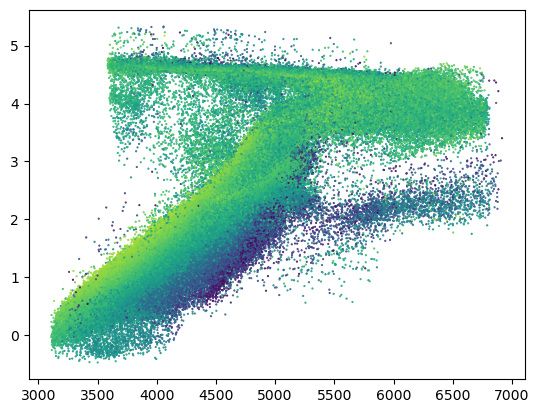

In [53]:
plt.scatter(ft_table['teff'],ft_table['logg'],c=ft_table['fe_h'],s=0.3)

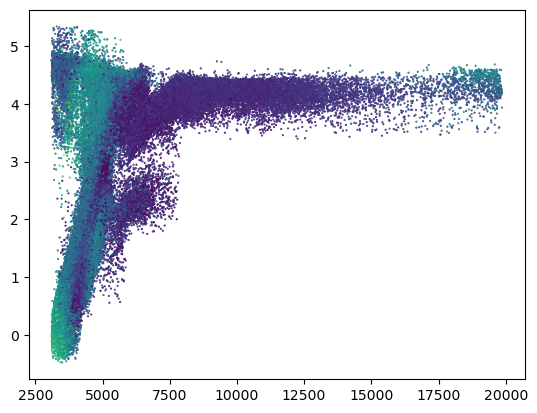

In [54]:
plt.scatter(ft_table['teff'],ft_table['logg'],c=ft_table['age'],s=0.3)

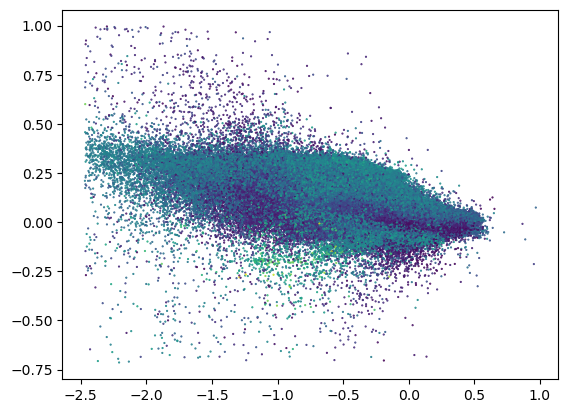

In [55]:
plt.scatter(ft_table['fe_h'],ft_table['alpha'],c=ft_table['age'],s=0.3)

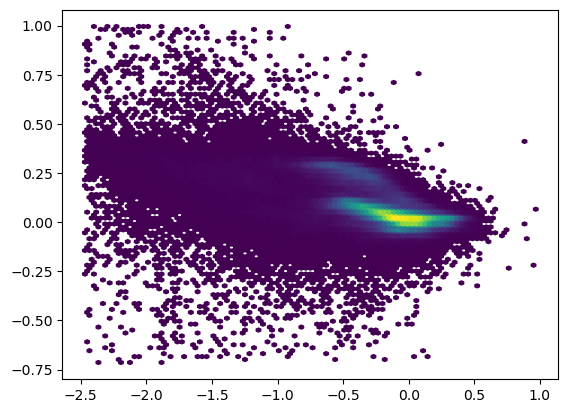

In [56]:
plt.hexbin(ft_table['fe_h'],ft_table['alpha'],mincnt=1,bins=400)

In [57]:
del data
del gaiadf
del gaiadata
del astronn1
del astronn2

In [58]:
towrite = Table.from_pandas(ft_table)
towrite.write('ft_apogee.fits',overwrite=True,format='fits')

## Grabbing GALAH

In [ ]:
data = Table.read('galah_dr4_allstar_240705.fits').to_pandas()

In [10]:
# same as with APOGEE
data = data[~data.duplicated(subset='gaiadr3_source_id', keep=False)]
data.gaiadr3_source_id.value_counts()

gaiadr3_source_id
2745049530295263232    1
6050444709053173120    1
5807361418514852992    1
4345432169593473280    1
5807167354708349824    1
                      ..
5202071574398480768    1
5306087435993175808    1
5247509132942850560    1
5219293255086154496    1
1823067317695766784    1
Name: count, Length: 917570, dtype: int64

In [11]:
# checking which columns there are for the next step
data

sobject_id             tmass_id    gaiadr3_source_id  \
0       170910004101274  b'00000011+0522500'  2745049530295263232   
1       161116001701360  b'00000023-5709445'  4922452332795612416   
2       161116001701016  b'00000024-5742487'  4919409709243747968   
3       140713004601361  b'00000025-7541166'  4685221429109310080   
4       140708007101175  b'00000038-7756270'  4683766775225601664   
...                 ...                  ...                  ...   
917581  200801005101094  b'23595927-5421225'  6497193020903183616   
917582  170711005801294  b'23595970-6314456'  6487444097976387328   
917583  200801005101309  b'23595997-5257480'  4972343703699453696   
917584  230511002201040  b'Checked_No_2MASS'  3900956037171845888   
917586  140709004401117           b'gam Sge'  1823067317695766784   

           survey_name  field_id       setup           mjd          ra  \
0       b'galah_faint'      6882  b'allstar'  58006.613281    0.000500   
1       b'galah_faint'      6863  b'allstar'  57708.425781    0.001000   
2       b'galah_faint'      6863  b'allstar'  57708.425781    0.001000   
3        b'galah_main'       182  b'allstar'  56851.773438    0.001042   
4        b'galah_main'       245  b'allstar'  56846.816406    0.001583   
...                ...       ...         ...           ...         ...   
917581  b'galah_faint'      6834  b'allstar'  59062.746094  359.997070   
917582  b'galah_faint'      6966  b'allstar'  57945.796875  359.998779   
917583  b'galah_faint'      6834  b'allstar'  59062.746094    0.000167   
917584        b'buder'       -11  b'allstar'  60075.480469  187.837875   
917586      b'gam_sag'        -2  b'allstar'  56847.687500  299.689301   

              dec  flag_sp  flag_sp_fit  opt_loop  flag_red  snr_px_ccd1  \
0        5.380556        0            0         2         0    26.964375   
1      -57.162334        0            0         2         0    39.684574   
2      -57.713528        0            0         2      3072    48.891308   
3      -75.687943        0            0         2         0    54.512363   
4      -77.940865        0            0         2         0    29.289726   
...           ...      ...          ...       ...       ...          ...   
917581 -54.356224        0            0         2         0    37.079647   
917582 -63.245998        0            0         2         0    27.925461   
917583 -52.963306        0            0         2         0    34.480110   
917584   7.642056    16896           64        -1         0    52.546589   
917586  19.492147        8            0         2    524288   816.767822   

        snr_px_ccd2  snr_px_ccd3  snr_px_ccd4    chi2_sp  px_used_perc  \
0         45.697865    75.889725    72.905983   1.161375            94   
1         52.617100    66.097115    56.828625   0.677067            94   
2         66.277039    81.093063    72.222115   0.654089            94   
3         74.712013    97.874832    91.115067   0.863295            94   
4         42.882103    55.286251    53.542664   0.716525            94   
...             ...          ...          ...        ...           ...   
917581    53.673565    70.699158    61.831562   0.750693            94   
917582    34.732021    45.685043    39.163834   0.656969            94   
917583    42.853783    56.833721    39.000278   0.670460            94   
917584    68.682396    84.451851    71.217163        NaN             0   
917586  1957.693237  1566.856445  1015.909424  40.094460            94   

                model_name       closest_model   comp_time  fit_global_rv  \
0       b'4500_4.50_-0.50'  b'4500_4.50_-0.50'  134.001373           True   
1       b'4750_4.50_-1.00'  b'5000_4.50_-1.00'   99.244652           True   
2       b'5500_4.00_-0.75'  b'5500_4.00_-0.75'  282.589783           True   
3        b'5500_4.50_0.00'   b'5500_4.50_0.00'  152.948715           True   
4       b'5000_3.00_-0.75'  b'5000_3.00_-0.75'   80.213524           True   
...                    ...     

In [12]:
# calculating the alpha/fe ratio for the dataset then saving that in a separate column, accounting for the poor measurements

# Define valid flags (only keep 0 and 1)
valid_flags = {0, 1} # 0 - no problems, 1 - upper limit, all others are pretty drastic

# List of alpha-elements and their corresponding flag columns
alpha_elements = ['mg_fe','si_fe','ca_fe','ti_fe','o_fe']
flag_columns = ['flag_mg_fe','flag_si_fe','flag_ca_fe','flag_ti_fe','flag_o_fe']
e_alpha_elements = ['e_mg_fe','e_si_fe','e_ca_fe','e_ti_fe','e_o_fe']	
# Mask out invalid values based on flags
for elem, flag in zip(alpha_elements, flag_columns):
    data[elem] = np.where(data[flag].isin(valid_flags), data[elem], np.nan)

# Compute [α/Fe] as the mean of valid elements (ignoring NaNs)
data['alpha'] = data[alpha_elements].mean(axis=1, skipna=True)
data['e_alpha'] = data[e_alpha_elements].mean(axis=1, skipna=True)
data['e_age'] = np.sqrt(data['age']) # there are no quoted uncertainties so a sqrt is what I shall use

In [13]:
# filtering out the numerous columns for lightweight matching
cols_to_keep = ['gaiadr3_source_id','teff','e_teff','logg','e_logg','fe_h','e_fe_h','alpha','e_alpha','age','e_age']
data = data[cols_to_keep]
data

gaiadr3_source_id         teff     e_teff      logg    e_logg  \
0       2745049530295263232  4486.255371  68.002647  4.657445  0.100572   
1       4922452332795612416  4900.511719  72.155556  4.464450  0.102015   
2       4919409709243747968  5543.346191  73.427536  4.175371  0.102718   
3       4685221429109310080  5529.029297  68.877304  4.521021  0.104782   
4       4683766775225601664  4977.451172  74.996758  3.172151  0.113069   
...                     ...          ...        ...       ...       ...   
917581  6497193020903183616  5428.497070  71.351089  4.455420  0.094237   
917582  6487444097976387328  5902.784180  71.711464  4.012203  0.103693   
917583  4972343703699453696  5399.747559  74.916428  4.333981  0.109745   
917584  3900956037171845888          NaN        NaN       NaN       NaN   
917586  1823067317695766784  3983.621582  66.341682  1.188985       NaN   

            fe_h    e_fe_h     alpha   e_alpha        age     e_age  
0      -0.396317  0.055118  0.153393  0.024897   3.215799  1.793265  
1      -1.032346  0.065797  0.231157  0.042733   0.017005  0.130402  
2      -0.654349  0.064612  0.292858  0.041623  13.842698  3.720578  
3       0.135527  0.056800 -0.009852  0.028337   3.414711  1.847894  
4      -0.612790  0.065126  0.292203  0.056503  10.581185  3.252873  
...          ...       ...       ...       ...        ...       ...  
917581  0.010281  0.058745  0.058530  0.036419   8.834783  2.972336  
917582 -0.415962  0.064327  0.114116  0.056338   9.151339  3.025118  
917583 -0.095362  0.061213  0.053171  0.043947  13.606515  3.688701  
917584       NaN       NaN       NaN       NaN        NaN       NaN  
917586 -0.239987  0.053988  0.102499  0.007309   4.350832  2.085865  

[917570 rows x 11 columns]

In [15]:
gaiadata = []
with h5py.File('220M_pretrain_data.h5','r') as f:
    progress_bar = tqdm(f.keys(),total=len(f.keys()))
    for key in progress_bar:
        mask = np.isin(f[key][:]['source_id'], data['gaiadr3_source_id'])
        gaiadata.extend([list(tup) for tup in f[key][:][mask]])
    dtypes = f['sslset0_part0'].dtype
    columns = list(dtypes.names)
    f.close()

100%|██████████| 135/135 [32:13<00:00, 14.32s/it]


Using array below here completely turned everything to bytes

In [18]:
gaiadf = pd.DataFrame(data=gaiadata, columns=columns)

In [19]:
del gaiadata

In [20]:
gaiadf

source_id      W1      W2          G         BP         RP  \
0          1537946184929152  11.692  11.726  13.780051  14.253674  13.139469   
1          1540518869741440  10.546  10.579  12.035417  12.380647  11.523050   
2          1540694963998080  12.333  12.378  14.011831  14.400846  13.455057   
3          1541210360101376  11.107  11.137  12.614493  12.966586  12.093554   
4          1542928347017600  11.828  11.925  13.444496  13.780264  12.938136   
...                     ...     ...     ...        ...        ...        ...   
856256  2935921519073553920   9.611   9.722  12.970564  13.822083  12.068774   
856257  2935923992974214784  12.575  12.603  14.110112  14.468316  13.577037   
856258  2936000649548792320  10.208  10.228  12.242901  12.710995  11.603420   
856259  2936016420668418560  12.240  12.314  13.495056  13.732860  13.098709   
856260  2936020646916209536   9.222   9.430  12.867747  13.774617  11.932652   

                 bp_1           bp_2          bp_3         bp_4         bp_5  \
0       456232.833425  -39500.636394  -8834.415206  4904.428820 -4167.756575   
1       496668.258598  -76275.879113  -3724.847963  4473.104801 -3381.522181   
2       483589.654247  -62988.294513  -5950.800635  4420.123514 -3884.928899   
3       492690.011974  -74255.548581  -3968.194033  3716.729451 -2747.519834   
4       493054.177518  -83041.826116   1437.931759  1496.796358 -2233.809778   
...               ...            ...           ...          ...          ...   
856256  368394.313490   45687.588438 -24501.648525  -171.146463 -4149.095316   
856257  487923.253283  -80436.425459  -2899.506107  2660.915629 -2330.734908   
856258  461265.966892  -35074.512735 -10782.438805  3425.080614 -3204.782329   
856259  514670.288700 -131963.563080  13072.959641 -2744.380505   401.304945   
856260  350604.108018   46406.379628 -17627.474852 -3306.534769 -2934.178646   

               bp_6         bp_7         bp_8         bp_9        bp_10  \
0       1554.882039 -1733.959863   888.280728  -968.105607   682.770680   
1      -2816.298164 -1867.662983  1349.014368 -1427.876182  -102.984951   
2      -1854.995736 -1430.127094  1331.358291 -1978.894020   -33.476700   
3      -1020.368401 -1212.579753   557.460750   158.723045   247.281470   
4        103.528427  -758.623074   724.375131  -718.634703   -93.371167   
...             ...          ...          ...          ...          ...   
856256  6660.255659 -1028.808250   -23.391590 -1082.115542   579.101225   
856257  1973.813011  1519.150483  -961.932833  3081.386793  -859.606877   
856258 -1271.352235 -1836.067966  1629.147655  -574.436579   168.463035   
856259  4103.471037  4506.167916 -2417.913181  7592.658219 -1530.562725   
856260  3885.657886  -911.576991   -12.034054  -241.018832   504.752630   

             bp_11       bp_12        bp_13       bp_14       bp_15  \
0       168.388478   42.314667 -1246.406299  187.985846  382.534943   
1        49.435660  211.587096  -211.816138  -81.447606   74.238210   
2        82.966580  272.019814  -934.740548 -226.347137  458.205213   
3       579.517802   64.327766   456.103787  -73.369574   94.740690   
4      -491.349228  145.145705  -270.451090 -257.188078  373.418055   
...            ...         ...          ...         ...         ...   
856256 -194.675789  -13.951171  -640.391070 -226.583107  -57.677540   
856257  789.646448 -668.653033  -340.726198 -588.099103  -73.877816   
856258  306.867344  307.447291   117.406227  -39.844634  -87.949459   
856259  570.557885 -408.994250  -304.686014 -948.736314  326.146196   
856260  333.901522  393.951109  -208.679833 -274.980386   21.343276   

              bp_16        bp_17       bp_18        bp_19        bp_20  \
0        396.764392    35.079507  180.552817  -952.758088    19.813595   
1       -250.618595   388.741197   90.042807  -398.026652  -261.729231   
2         86.506002   167.384790  506.588291  -590.237878  -159.202408   
3       -316.585796   924.716756 -123.933004  

In [21]:
cols_to_check = ['U_SMSS','E_U_SMSS','V_SMSS','E_V_SMSS','G_SMSS','E_G_SMSS','R_SMSS','E_R_SMSS','I_SMSS','E_I_SMSS','Z_SMSS','E_Z_SMSS',
                 'U_SDSS','E_U_SDSS','G_SDSS','E_G_SDSS','R_SDSS','E_R_SDSS','I_SDSS','E_I_SDSS','Z_SDSS','E_Z_SDSS','G_PS1','E_G_PS1',
                'R_PS1','E_R_PS1','I_PS1','E_I_PS1','Z_PS1','E_Z_PS1','Y_PS1','E_Y_PS1']

In [22]:
for col in cols_to_check:
    gaiadf[col] = [np.nan if v in {b'', ''} else float(v) for v in gaiadf[col]]
    gaiadf[col] = gaiadf[col].astype('float64')

In [23]:
gaiadf

source_id      W1      W2          G         BP         RP  \
0          1537946184929152  11.692  11.726  13.780051  14.253674  13.139469   
1          1540518869741440  10.546  10.579  12.035417  12.380647  11.523050   
2          1540694963998080  12.333  12.378  14.011831  14.400846  13.455057   
3          1541210360101376  11.107  11.137  12.614493  12.966586  12.093554   
4          1542928347017600  11.828  11.925  13.444496  13.780264  12.938136   
...                     ...     ...     ...        ...        ...        ...   
856256  2935921519073553920   9.611   9.722  12.970564  13.822083  12.068774   
856257  2935923992974214784  12.575  12.603  14.110112  14.468316  13.577037   
856258  2936000649548792320  10.208  10.228  12.242901  12.710995  11.603420   
856259  2936016420668418560  12.240  12.314  13.495056  13.732860  13.098709   
856260  2936020646916209536   9.222   9.430  12.867747  13.774617  11.932652   

                 bp_1           bp_2          bp_3         bp_4         bp_5  \
0       456232.833425  -39500.636394  -8834.415206  4904.428820 -4167.756575   
1       496668.258598  -76275.879113  -3724.847963  4473.104801 -3381.522181   
2       483589.654247  -62988.294513  -5950.800635  4420.123514 -3884.928899   
3       492690.011974  -74255.548581  -3968.194033  3716.729451 -2747.519834   
4       493054.177518  -83041.826116   1437.931759  1496.796358 -2233.809778   
...               ...            ...           ...          ...          ...   
856256  368394.313490   45687.588438 -24501.648525  -171.146463 -4149.095316   
856257  487923.253283  -80436.425459  -2899.506107  2660.915629 -2330.734908   
856258  461265.966892  -35074.512735 -10782.438805  3425.080614 -3204.782329   
856259  514670.288700 -131963.563080  13072.959641 -2744.380505   401.304945   
856260  350604.108018   46406.379628 -17627.474852 -3306.534769 -2934.178646   

               bp_6         bp_7         bp_8         bp_9        bp_10  \
0       1554.882039 -1733.959863   888.280728  -968.105607   682.770680   
1      -2816.298164 -1867.662983  1349.014368 -1427.876182  -102.984951   
2      -1854.995736 -1430.127094  1331.358291 -1978.894020   -33.476700   
3      -1020.368401 -1212.579753   557.460750   158.723045   247.281470   
4        103.528427  -758.623074   724.375131  -718.634703   -93.371167   
...             ...          ...          ...          ...          ...   
856256  6660.255659 -1028.808250   -23.391590 -1082.115542   579.101225   
856257  1973.813011  1519.150483  -961.932833  3081.386793  -859.606877   
856258 -1271.352235 -1836.067966  1629.147655  -574.436579   168.463035   
856259  4103.471037  4506.167916 -2417.913181  7592.658219 -1530.562725   
856260  3885.657886  -911.576991   -12.034054  -241.018832   504.752630   

             bp_11       bp_12        bp_13       bp_14       bp_15  \
0       168.388478   42.314667 -1246.406299  187.985846  382.534943   
1        49.435660  211.587096  -211.816138  -81.447606   74.238210   
2        82.966580  272.019814  -934.740548 -226.347137  458.205213   
3       579.517802   64.327766   456.103787  -73.369574   94.740690   
4      -491.349228  145.145705  -270.451090 -257.188078  373.418055   
...            ...         ...          ...         ...         ...   
856256 -194.675789  -13.951171  -640.391070 -226.583107  -57.677540   
856257  789.646448 -668.653033  -340.726198 -588.099103  -73.877816   
856258  306.867344  307.447291   117.406227  -39.844634  -87.949459   
856259  570.557885 -408.994250  -304.686014 -948.736314  326.146196   
856260  333.901522  393.951109  -208.679833 -274.980386   21.343276   

              bp_16        bp_17       bp_18        bp_19        bp_20  \
0        396.764392    35.079507  180.552817  -952.758088    19.813595   
1       -250.618595   388.741197   90.042807  -398.026652  -261.729231   
2         86.506002   167.384790  506.588291  -590.237878  -159.202408   
3       -316.585796   924.716756 -123.933004  

In [24]:
ft_table = pd.merge(data, gaiadf, how='left', left_on='gaiadr3_source_id', right_on='source_id')

In [26]:
ft_table

gaiadr3_source_id         teff     e_teff      logg    e_logg  \
0       2745049530295263232  4486.255371  68.002647  4.657445  0.100572   
1       4922452332795612416  4900.511719  72.155556  4.464450  0.102015   
2       4919409709243747968  5543.346191  73.427536  4.175371  0.102718   
3       4685221429109310080  5529.029297  68.877304  4.521021  0.104782   
4       4683766775225601664  4977.451172  74.996758  3.172151  0.113069   
...                     ...          ...        ...       ...       ...   
917565  6497193020903183616  5428.497070  71.351089  4.455420  0.094237   
917566  6487444097976387328  5902.784180  71.711464  4.012203  0.103693   
917567  4972343703699453696  5399.747559  74.916428  4.333981  0.109745   
917568  3900956037171845888          NaN        NaN       NaN       NaN   
917569  1823067317695766784  3983.621582  66.341682  1.188985       NaN   

            fe_h    e_fe_h     alpha   e_alpha        age     e_age  \
0      -0.396317  0.055118  0.153393  0.024897   3.215799  1.793265   
1      -1.032346  0.065797  0.231157  0.042733   0.017005  0.130402   
2      -0.654349  0.064612  0.292858  0.041623  13.842698  3.720578   
3       0.135527  0.056800 -0.009852  0.028337   3.414711  1.847894   
4      -0.612790  0.065126  0.292203  0.056503  10.581185  3.252873   
...          ...       ...       ...       ...        ...       ...   
917565  0.010281  0.058745  0.058530  0.036419   8.834783  2.972336   
917566 -0.415962  0.064327  0.114116  0.056338   9.151339  3.025118   
917567 -0.095362  0.061213  0.053171  0.043947  13.606515  3.688701   
917568       NaN       NaN       NaN       NaN        NaN       NaN   
917569 -0.239987  0.053988  0.102499  0.007309   4.350832  2.085865   

           source_id      W1      W2          G         BP         RP  \
0                NaN     NaN     NaN        NaN        NaN        NaN   
1       4.922452e+18  11.589  11.611  13.600912  14.048682  12.978907   
2       4.919410e+18  11.803  11.835  13.280836  13.597154  12.787919   
3       4.685221e+18  10.633  10.665  12.207837  12.582831  11.667729   
4       4.683767e+18  10.843  10.889  12.944366  13.427569  12.295570   
...              ...     ...     ...        ...        ...        ...   
917565  6.497193e+18  12.360  12.398  13.934263  14.306655  13.400787   
917566  6.487444e+18  11.472  11.493  12.703551  12.974706  12.273364   
917567  4.972344e+18  11.784  11.826  13.546202  13.941154  12.978876   
917568  3.900956e+18     NaN     NaN  13.402974  13.661360  12.984175   
917569  1.823067e+18     NaN     NaN   2.859363   3.947543   2.250542   

                 bp_1           bp_2          bp_3          bp_4         bp_5  \
0                 NaN            NaN           NaN           NaN          NaN   
1       464745.307410  -45230.418659  -8403.841114   1867.043248  -930.110770   
2       497179.163727  -89026.225473   1019.368811   2152.576259 -1849.357944   
3       491913.513358  -64128.449378  -8634.507072   5833.671329 -2770.435999   
4       459335.964422  -33738.972648 -12738.898262   6044.675592 -4314.122586   
...               ...            ...           ...           ...          ...   
917565  491444.183496  -65474.835649  -7513.421226   5457.362596 -3472.243395   
917566  508593.740010 -108754.988185   7333.749417    751.528263 -1944.622822   
917567  482419.021684  -59441.632202  -7712.346700   4187.848853 -2425.284304   
917568  509209.324629 -114726.594125  10929.671041  -1211.475381 -1718.157938   
917569  277865.807960    7467.009388  -3102.381231  21802.255711  4527.965587   

               bp_6          bp_7         bp_8         bp_9        bp_10  \
0               NaN           NaN          NaN          NaN          NaN   
1      -3820.129248  -2076.630945   671.645347 -1613.233751  -583.173389   
2      -1212.715970  -2916.398146   116.486983 -1700.052917   301.323849   
3      -4323.433358  -2328.726877  1376.272557 -1070.795475   -20.692233   
4      -1389.673243  -1983

In [27]:
ft_table = ft_table.drop(columns='source_id')

In [28]:
ft_table

gaiadr3_source_id         teff     e_teff      logg    e_logg  \
0       2745049530295263232  4486.255371  68.002647  4.657445  0.100572   
1       4922452332795612416  4900.511719  72.155556  4.464450  0.102015   
2       4919409709243747968  5543.346191  73.427536  4.175371  0.102718   
3       4685221429109310080  5529.029297  68.877304  4.521021  0.104782   
4       4683766775225601664  4977.451172  74.996758  3.172151  0.113069   
...                     ...          ...        ...       ...       ...   
917565  6497193020903183616  5428.497070  71.351089  4.455420  0.094237   
917566  6487444097976387328  5902.784180  71.711464  4.012203  0.103693   
917567  4972343703699453696  5399.747559  74.916428  4.333981  0.109745   
917568  3900956037171845888          NaN        NaN       NaN       NaN   
917569  1823067317695766784  3983.621582  66.341682  1.188985       NaN   

            fe_h    e_fe_h     alpha   e_alpha        age     e_age      W1  \
0      -0.396317  0.055118  0.153393  0.024897   3.215799  1.793265     NaN   
1      -1.032346  0.065797  0.231157  0.042733   0.017005  0.130402  11.589   
2      -0.654349  0.064612  0.292858  0.041623  13.842698  3.720578  11.803   
3       0.135527  0.056800 -0.009852  0.028337   3.414711  1.847894  10.633   
4      -0.612790  0.065126  0.292203  0.056503  10.581185  3.252873  10.843   
...          ...       ...       ...       ...        ...       ...     ...   
917565  0.010281  0.058745  0.058530  0.036419   8.834783  2.972336  12.360   
917566 -0.415962  0.064327  0.114116  0.056338   9.151339  3.025118  11.472   
917567 -0.095362  0.061213  0.053171  0.043947  13.606515  3.688701  11.784   
917568       NaN       NaN       NaN       NaN        NaN       NaN     NaN   
917569 -0.239987  0.053988  0.102499  0.007309   4.350832  2.085865     NaN   

            W2          G         BP         RP           bp_1           bp_2  \
0          NaN        NaN        NaN        NaN            NaN            NaN   
1       11.611  13.600912  14.048682  12.978907  464745.307410  -45230.418659   
2       11.835  13.280836  13.597154  12.787919  497179.163727  -89026.225473   
3       10.665  12.207837  12.582831  11.667729  491913.513358  -64128.449378   
4       10.889  12.944366  13.427569  12.295570  459335.964422  -33738.972648   
...        ...        ...        ...        ...            ...            ...   
917565  12.398  13.934263  14.306655  13.400787  491444.183496  -65474.835649   
917566  11.493  12.703551  12.974706  12.273364  508593.740010 -108754.988185   
917567  11.826  13.546202  13.941154  12.978876  482419.021684  -59441.632202   
917568     NaN  13.402974  13.661360  12.984175  509209.324629 -114726.594125   
917569     NaN   2.859363   3.947543   2.250542  277865.807960    7467.009388   

                bp_3          bp_4         bp_5         bp_6          bp_7  \
0                NaN           NaN          NaN          NaN           NaN   
1       -8403.841114   1867.043248  -930.110770 -3820.129248  -2076.630945   
2        1019.368811   2152.576259 -1849.357944 -1212.715970  -2916.398146   
3       -8634.507072   5833.671329 -2770.435999 -4323.433358  -2328.726877   
4      -12738.898262   6044.675592 -4314.122586 -1389.673243  -1983.054784   
...              ...           ...          ...          ...           ...   
917565  -7513.421226   5457.362596 -3472.243395 -5315.744540  -2497.501832   
917566   7333.749417    751.528263 -1944.622822  -694.355565   -935.117848   
917567  -7712.346700   4187.848853 -2425.284304 -3881.158334  -2419.531575   
917568  10929.671041  -1211.475381 -1718.157938   182.676462   -701.210855   
917569  -3102.381231  21802.255711  4527.965587 -3479.647835 -11143.009768   

               bp_8         bp_9        bp_10       bp_11        bp_12  \
0               NaN          NaN          NaN         NaN          NaN   
1        671.645347 -1613.233751  -583.173389 -264.907822   258.211195   
2        116.486983 -1700.05

In [29]:
ft_table.rename(columns={'gaiadr3_source_id': 'source_id'}, inplace=True)

In [30]:
ft_table

source_id         teff     e_teff      logg    e_logg  \
0       2745049530295263232  4486.255371  68.002647  4.657445  0.100572   
1       4922452332795612416  4900.511719  72.155556  4.464450  0.102015   
2       4919409709243747968  5543.346191  73.427536  4.175371  0.102718   
3       4685221429109310080  5529.029297  68.877304  4.521021  0.104782   
4       4683766775225601664  4977.451172  74.996758  3.172151  0.113069   
...                     ...          ...        ...       ...       ...   
917565  6497193020903183616  5428.497070  71.351089  4.455420  0.094237   
917566  6487444097976387328  5902.784180  71.711464  4.012203  0.103693   
917567  4972343703699453696  5399.747559  74.916428  4.333981  0.109745   
917568  3900956037171845888          NaN        NaN       NaN       NaN   
917569  1823067317695766784  3983.621582  66.341682  1.188985       NaN   

            fe_h    e_fe_h     alpha   e_alpha        age     e_age      W1  \
0      -0.396317  0.055118  0.153393  0.024897   3.215799  1.793265     NaN   
1      -1.032346  0.065797  0.231157  0.042733   0.017005  0.130402  11.589   
2      -0.654349  0.064612  0.292858  0.041623  13.842698  3.720578  11.803   
3       0.135527  0.056800 -0.009852  0.028337   3.414711  1.847894  10.633   
4      -0.612790  0.065126  0.292203  0.056503  10.581185  3.252873  10.843   
...          ...       ...       ...       ...        ...       ...     ...   
917565  0.010281  0.058745  0.058530  0.036419   8.834783  2.972336  12.360   
917566 -0.415962  0.064327  0.114116  0.056338   9.151339  3.025118  11.472   
917567 -0.095362  0.061213  0.053171  0.043947  13.606515  3.688701  11.784   
917568       NaN       NaN       NaN       NaN        NaN       NaN     NaN   
917569 -0.239987  0.053988  0.102499  0.007309   4.350832  2.085865     NaN   

            W2          G         BP         RP           bp_1           bp_2  \
0          NaN        NaN        NaN        NaN            NaN            NaN   
1       11.611  13.600912  14.048682  12.978907  464745.307410  -45230.418659   
2       11.835  13.280836  13.597154  12.787919  497179.163727  -89026.225473   
3       10.665  12.207837  12.582831  11.667729  491913.513358  -64128.449378   
4       10.889  12.944366  13.427569  12.295570  459335.964422  -33738.972648   
...        ...        ...        ...        ...            ...            ...   
917565  12.398  13.934263  14.306655  13.400787  491444.183496  -65474.835649   
917566  11.493  12.703551  12.974706  12.273364  508593.740010 -108754.988185   
917567  11.826  13.546202  13.941154  12.978876  482419.021684  -59441.632202   
917568     NaN  13.402974  13.661360  12.984175  509209.324629 -114726.594125   
917569     NaN   2.859363   3.947543   2.250542  277865.807960    7467.009388   

                bp_3          bp_4         bp_5         bp_6          bp_7  \
0                NaN           NaN          NaN          NaN           NaN   
1       -8403.841114   1867.043248  -930.110770 -3820.129248  -2076.630945   
2        1019.368811   2152.576259 -1849.357944 -1212.715970  -2916.398146   
3       -8634.507072   5833.671329 -2770.435999 -4323.433358  -2328.726877   
4      -12738.898262   6044.675592 -4314.122586 -1389.673243  -1983.054784   
...              ...           ...          ...          ...           ...   
917565  -7513.421226   5457.362596 -3472.243395 -5315.744540  -2497.501832   
917566   7333.749417    751.528263 -1944.622822  -694.355565   -935.117848   
917567  -7712.346700   4187.848853 -2425.284304 -3881.158334  -2419.531575   
917568  10929.671041  -1211.475381 -1718.157938   182.676462   -701.210855   
917569  -3102.381231  21802.255711  4527.965587 -3479.647835 -11143.009768   

               bp_8         bp_9        bp_10       bp_11        bp_12  \
0               NaN          NaN          NaN         NaN          NaN   
1        671.645347 -1613.233751  -583.173389 -264.907822   258.211195   
2        116.486983 -1700.052917   3

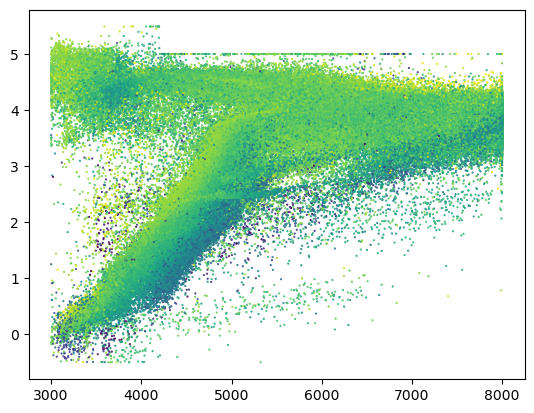

In [31]:
plt.scatter(ft_table['teff'],ft_table['logg'],c=ft_table['fe_h'],s=0.3)

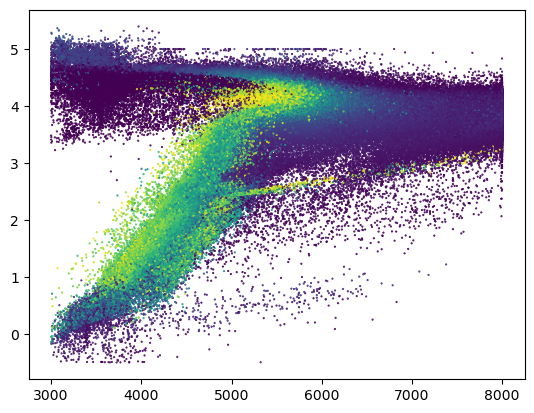

In [32]:
plt.scatter(ft_table['teff'],ft_table['logg'],c=ft_table['age'],s=0.3)

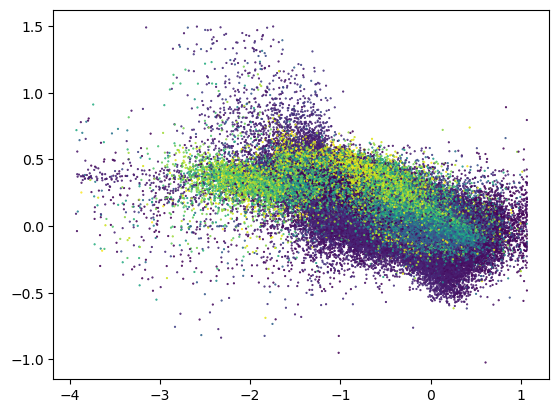

In [33]:
plt.scatter(ft_table['fe_h'],ft_table['alpha'],c=ft_table['age'],s=0.3)

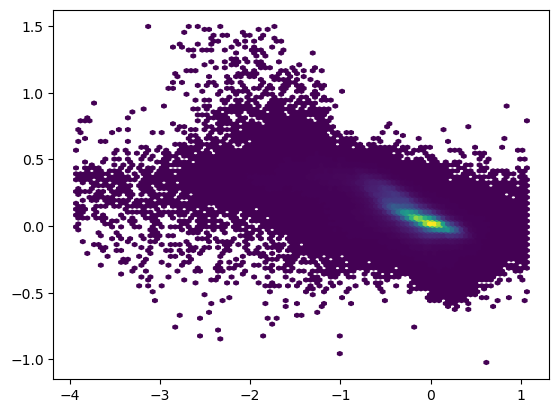

In [34]:
plt.hexbin(ft_table['fe_h'],ft_table['alpha'],mincnt=1,bins=400)

In [57]:
del data
del gaiadf

In [35]:
towrite = Table.from_pandas(ft_table)
towrite.write('ft_galah.fits',overwrite=True,format='fits')

## Combining GALAH and APOGEE

In [4]:
ft_table = Table.read('ft_apogee.fits').to_pandas()
galah = Table.read('ft_galah.fits').to_pandas()

In [5]:
ft_table.describe()

source_id           teff         e_teff           logg  \
count  5.914990e+05  560381.000000  560381.000000  560381.000000   
mean   3.024919e+18    4952.934082      25.774536       3.016287   
std    1.817109e+18    1284.999268      69.289841       1.231835   
min    9.281425e+12    3088.049805       2.461126      -0.473392   
25%    1.451486e+18    4357.337891       8.380351       2.193274   
50%    3.123882e+18    4771.925781      12.417188       2.814373   
75%    4.271912e+18    5125.395508      22.622633       4.275385   
max    6.917523e+18   19863.927734   11277.411133       5.391378   

              e_logg           fe_h         e_fe_h          alpha  \
count  560381.000000  530202.000000  530202.000000  529904.000000   
mean        0.034057      -0.231558       0.010797       0.073190   
std         0.045015       0.382288       0.025176       0.103290   
min         0.011192      -2.468600       0.003098      -0.713885   
25%         0.023264      -0.401570       0.006705       0.006583   
50%         0.027622      -0.174450       0.008391       0.043519   
75%         0.034560       0.015832       0.010736       0.109532   
max         6.477190       0.968570       4.064234       0.995405   

             e_alpha            age  ...           ruwe           pmra  \
count  529904.000000  566168.000000  ...  517478.000000  517478.000000   
mean        0.028233       5.964135  ...       1.496322      -2.217433   
std         0.102697       2.862477  ...       2.497080      26.531370   
min         0.002055       0.104433  ...       0.359607   -1573.040224   
25%         0.006095       3.502972  ...       0.979839      -4.875763   
50%         0.008274       5.960162  ...       1.032526      -1.213709   
75%         0.012814       8.367830  ...       1.125972       1.791652   
max        19.249155      19.931976  ...      95.250259    2891.518077   

               pmdec         e_pmra        e_pmdec   pmradec_corr  \
count  517478.000000  517478.000000  517478.000000  517478.000000   
mean       -5.012490       0.034914       0.030703       0.003007   
std        26.468307       0.053053       0.046794       0.222654   
min     -1738.286102       0.005280       0.005924      -0.906645   
25%        -7.213533       0.015039       0.014006      -0.139677   
50%        -2.599892       0.020788       0.018238       0.001313   
75%         0.526135       0.033886       0.029491       0.151352   
max      1279.193299       0.905524       0.856535       0.946043   

       g_flux_error  bp_flux_error  rp_flux_error     e_parallax  
count  5.174780e+05   5.174780e+05   5.174780e+05  517478.000000  
mean   2.306389e+02   3.240863e+02   4.609049e+02       0.032829  
std    9.268409e+03   1.532185e+04   2.492473e+04       0.050378  
min    9.532307e-01   2.235161e+00   3.943031e+00       0.007283  
25%    7.315214e+00   1.487355e+01   2.093091e+01       0.014595  
50%    2.089626e+01   3.178539e+01   4.196284e+01       0.019761  
75%    6.734319e+01   8.918423e+01   1.057002e+02       0.031176  
max    5.219406e+06   6.885736e+06   1.319446e+07       1.083091  

[8 rows x 288 columns]

In [64]:
ft_table.dropna(subset='teff',inplace=True)

In [65]:
galah

source_id         teff     e_teff      logg    e_logg  \
0       2745049530295263232  4486.255371  68.002647  4.657445  0.100572   
1       4922452332795612416  4900.511719  72.155556  4.464450  0.102015   
2       4919409709243747968  5543.346191  73.427536  4.175371  0.102718   
3       4685221429109310080  5529.029297  68.877304  4.521021  0.104782   
4       4683766775225601664  4977.451172  74.996758  3.172151  0.113069   
...                     ...          ...        ...       ...       ...   
917565  6497193020903183616  5428.497070  71.351089  4.455420  0.094237   
917566  6487444097976387328  5902.784180  71.711464  4.012203  0.103693   
917567  4972343703699453696  5399.747559  74.916428  4.333981  0.109745   
917568  3900956037171845888          NaN        NaN       NaN       NaN   
917569  1823067317695766784  3983.621582  66.341682  1.188985       NaN   

            fe_h    e_fe_h     alpha   e_alpha        age     e_age      W1  \
0      -0.396317  0.055118  0.153393  0.024897   3.215799  1.793265     NaN   
1      -1.032346  0.065797  0.231157  0.042733   0.017005  0.130402  11.589   
2      -0.654349  0.064612  0.292858  0.041623  13.842698  3.720578  11.803   
3       0.135527  0.056800 -0.009852  0.028337   3.414711  1.847894  10.633   
4      -0.612790  0.065126  0.292203  0.056503  10.581185  3.252873  10.843   
...          ...       ...       ...       ...        ...       ...     ...   
917565  0.010281  0.058745  0.058530  0.036419   8.834783  2.972336  12.360   
917566 -0.415962  0.064327  0.114116  0.056338   9.151339  3.025118  11.472   
917567 -0.095362  0.061213  0.053171  0.043947  13.606515  3.688701  11.784   
917568       NaN       NaN       NaN       NaN        NaN       NaN     NaN   
917569 -0.239987  0.053988  0.102499  0.007309   4.350832  2.085865     NaN   

            W2          G         BP         RP           bp_1           bp_2  \
0          NaN        NaN        NaN        NaN            NaN            NaN   
1       11.611  13.600912  14.048682  12.978907  464745.307410  -45230.418659   
2       11.835  13.280836  13.597154  12.787919  497179.163727  -89026.225473   
3       10.665  12.207837  12.582831  11.667729  491913.513358  -64128.449378   
4       10.889  12.944366  13.427569  12.295570  459335.964422  -33738.972648   
...        ...        ...        ...        ...            ...            ...   
917565  12.398  13.934263  14.306655  13.400787  491444.183496  -65474.835649   
917566  11.493  12.703551  12.974706  12.273364  508593.740010 -108754.988185   
917567  11.826  13.546202  13.941154  12.978876  482419.021684  -59441.632202   
917568     NaN  13.402974  13.661360  12.984175  509209.324629 -114726.594125   
917569     NaN   2.859363   3.947543   2.250542  277865.807960    7467.009388   

                bp_3          bp_4         bp_5         bp_6          bp_7  \
0                NaN           NaN          NaN          NaN           NaN   
1       -8403.841114   1867.043248  -930.110770 -3820.129248  -2076.630945   
2        1019.368811   2152.576259 -1849.357944 -1212.715970  -2916.398146   
3       -8634.507072   5833.671329 -2770.435999 -4323.433358  -2328.726877   
4      -12738.898262   6044.675592 -4314.122586 -1389.673243  -1983.054784   
...              ...           ...          ...          ...           ...   
917565  -7513.421226   5457.362596 -3472.243395 -5315.744540  -2497.501832   
917566   7333.749417    751.528263 -1944.622822  -694.355565   -935.117848   
917567  -7712.346700   4187.848853 -2425.284304 -3881.158334  -2419.531575   
917568  10929.671041  -1211.475381 -1718.157938   182.676462   -701.210855   
917569  -3102.381231  21802.255711  4527.965587 -3479.647835 -11143.009768   

               bp_8         bp_9        bp_10       bp_11        bp_12  \
0               NaN          NaN          NaN         NaN          NaN   
1        671.645347 -1613.233751  -583.173389 -264.907822   258.211195   
2        116.486983 -1700.052917   3

In [66]:
galah.dropna(subset='teff',inplace=True)

In [67]:
ft_table['spec_source'] = 'apogee-latentage'
galah['spec_source'] = 'galah'
ft_set = pd.concat([galah, ft_table], ignore_index=True)

In [68]:
towrite = Table.from_pandas(ft_set)
towrite.write('/arc/projects/k-pop/catalogues/andrae2023/ftset_spec_ga_0602_realmags.fits',overwrite=True,format='fits')

In [69]:
ft_set.source_id.value_counts()

source_id
5267562747555988480    2
4666490423895957376    2
4654277014375117056    2
5482710372515586944    2
6235884461845547904    2
                      ..
3615271064798156416    1
5851102293223312640    1
5852416995530340480    1
6107596743645773312    1
2772098031734496512    1
Name: count, Length: 1417413, dtype: int64

## Grabbing Li+ 2022 VMPs

In [70]:
vmps = Table.read('li_et_al_x_gaiaids.fits').to_pandas()

In [71]:
vmps['source_id'] = vmps['source_id'].str.decode("utf-8").astype(int)

In [73]:
vmps

ID       RAdeg      DEdeg   RVel   SNR  Teff  e_Teff  logg  \
0    b'J0002+0343'    0.645994   3.727085  -91.4  23.7  6207     110  4.16   
1    b'J0003+1556'    0.795383  15.933828 -185.5  32.2  5302      45  2.31   
2    b'J0006+1057'    1.571676  10.961624 -312.4  20.9  4691      38  1.63   
3    b'J0013+2350'    3.463742  23.846972 -259.2  41.4  6093     120  3.98   
4    b'J0022+4254'    5.510848  42.916500 -183.3  23.2  6566     133  3.98   
..             ...         ...        ...    ...   ...   ...     ...   ...   
286  b'J2333+0505'  353.356537   5.085501 -136.9  28.2  5035      28  2.05   
287  b'J2333+1756'  353.352356  17.936150 -309.6  24.9  4736      35  1.74   
288  b'J2347+2851'  356.998260  28.858528 -241.3  71.3  4864      39  1.88   
289  b'J2349+3119'  357.373352  31.331707  -91.9  43.6  5064      35  2.50   
290  b'J2353+0714'  358.388763   7.233393 -180.9  37.0  4611      46  1.48   

     e_logg   FeH  e_FeH    vt  e_vt  logLum  e_logLum  f_logg  Teff-L  \
0      0.05 -3.02   0.24  1.19  0.30   0.307     0.060       0    6361   
1      0.08 -2.23   0.11  2.11  0.12   1.883     0.081       0    5289   
2      0.14 -3.15   0.14  2.51  0.11   2.350     0.140       1    5012   
3      0.04 -2.26   0.09  1.49  0.10   0.455     0.054       0    6238   
4      0.06 -2.99   0.25  0.96  0.30   0.585     0.072       0    6250   
..      ...   ...    ...   ...   ...     ...       ...     ...     ...   
286    0.06 -2.43   0.12  2.55  0.09   2.053     0.061       0    5039   
287    0.12 -3.22   0.11  2.07  0.10   2.257     0.120       1    4827   
288    0.05 -2.36   0.10  1.78  0.04   2.163     0.051       0    4991   
289    0.04 -2.01   0.09  1.47  0.03   1.613     0.041       0    5483   
290    0.12 -3.70   0.18  2.88  0.17   2.471     0.121       1    4988   

     logg-L  FeH-L            source_id   has_xp      dist  phot_g_mean_mag  \
0      4.30  -3.36  2740128975242655232  b'True'  0.000089        14.924105   
1      1.09  -2.62  2772216224937941760  b'True'  0.000044        12.084477   
2      1.72  -3.15  2765776046033609856  b'True'  0.000033        12.593480   
3      3.91  -2.20  2848805666604277120  b'True'  0.000330        12.159748   
4      4.04  -3.36   385205965989661568  b'True'  0.000026        14.845626   
..      ...    ...                  ...      ...       ...              ...   
286    1.27  -2.33  2660208219502547584  b'True'  0.000031        12.086527   
287    1.22  -3.35  2821294236410574080  b'True'  0.000027        14.463034   
288    1.27  -2.18  2866981452805072640  b'True'  0.000054        10.867290   
289    2.71  -2.07  2868460399023553664  b'True'  0.000095        11.889286   
290    2.22  -3.56  2746403063468526976  b'True'  0.000022        13.154490   

     phot_bp_mean_mag  phot_rp_mean_mag  
0           15.155141         14.532942  
1           12.461968         11.525990  
2           13.132258         11.893878  
3           12.425416         11.725774  
4           15.089993         14.433265  
..                ...               ...  
286         12.563046         11.435070  
287         14.995966         13.763576  
288         11.351499         10.204917  
289         12.374171         11.229742  
290         13.761119         12.401095  

[291 rows x 25 columns]

In [74]:
keep_cols = ['source_id','Teff','e_Teff','logg','e_logg','FeH','e_FeH']
rename_cols = ['source_id','teff','e_teff','logg','e_logg','fe_h','e_fe_h']
data = vmps[keep_cols]
data = data.rename(columns={'Teff': 'teff', 'e_Teff': 'e_teff', 'FeH':'fe_h', 'e_FeH':'e_fe_h'})

In [76]:
gaiadata = []
with h5py.File('220M_pretrain_data.h5','r') as f:
    progress_bar = tqdm(f.keys(),total=len(f.keys()))
    for key in progress_bar:
        mask = np.isin(f[key][:]['source_id'], data['source_id'])
        gaiadata.extend([list(tup) for tup in f[key][:][mask]])
    dtypes = f['sslset0_part0'].dtype
    columns = list(dtypes.names)
    f.close()

100%|██████████| 135/135 [26:22<00:00, 11.72s/it]


In [79]:
gaiadf = pd.DataFrame(data=gaiadata, columns=columns)

In [80]:
gaiadf

source_id      W1      W2          G         BP         RP  \
0      29184921251610880   9.937   9.962  12.024832  12.486258  11.384337   
1      47471831142473216  11.678  11.674  14.604343  15.336544  13.757987   
2      51853556778466304  11.405  11.381  14.474529  15.295352  13.578579   
3      53071884383335680  10.812  10.781  13.187760  13.743280  12.463184   
4      98134028414775552  13.060  13.089  14.319507  14.576004  13.898792   
..                   ...     ...     ...        ...        ...        ...   
286  2838297702698014464  11.936  11.936  13.264157  13.534019  12.822065   
287  2848805666604277120  10.834  10.851  12.159748  12.425416  11.725774   
288  2858388735073787776  13.609  13.640  14.899602  15.156439  14.468425   
289  2866981452805072640   8.710   8.719  10.867290  11.351499  10.204917   
290  2868460399023553664   9.774   9.785  11.889286  12.374171  11.229742   

              bp_1           bp_2          bp_3         bp_4         bp_5  \
0    456146.018324  -43896.642855  -4416.667888  2312.513410 -4564.901446   
1    383846.203033   15334.258722  -9288.751205 -1053.081459 -5080.050439   
2    363130.303933   30186.828813 -11885.656049 -2724.050369 -5662.706281   
3    426364.371485  -21638.002053  -5102.287936  -316.616775 -4496.476649   
4    505957.554438 -117453.408787  14053.141244 -3672.696802  -518.604709   
..             ...            ...           ...          ...          ...   
286  501011.710771 -112235.276440  13057.110648 -3176.959296  -660.444737   
287  501726.742228 -112722.730096  14038.130472 -4093.788042  -991.250680   
288  504367.742573 -114517.792466  14941.113129 -4272.619996  -838.177056   
289  450053.105501  -37031.003519  -3885.157657  2074.039094 -5063.361385   
290  448743.577068  -38002.040355  -4817.266997  1759.088982 -5064.191735   

            bp_6         bp_7         bp_8         bp_9       bp_10  \
0    3969.998780  -975.299693  -377.402652  -508.076258  463.658136   
1    7416.274350   -61.694758 -1135.886655   434.250249  760.089040   
2    6868.200108    41.915912 -1145.687331   157.855174  869.808884   
3    7176.957742  -100.818522  -358.829847   473.147657  222.919986   
4    4779.582526   399.426889  -164.027265   697.118359  595.889933   
..           ...          ...          ...          ...         ...   
286  4780.741914   284.993478   -85.587139 -1541.693279 -161.844081   
287  4298.344444   219.549414  -145.915919 -1171.355569  294.412104   
288  5333.322374   457.330473     8.212552 -1816.696613  653.401414   
289  3154.836709 -1236.558716   -43.333491 -1030.230650  309.734040   
290  4341.764142 -1294.417790   -50.036530 -1079.830793  361.975538   

          bp_11       bp_12        bp_13       bp_14       bp_15       bp_16  \
0    -30.461107  -29.676934  -740.929081   56.944696  450.217351  384.243363   
1   -532.201781  -30.571056  -530.617855 -274.812402 -188.435322  218.224049   
2    405.984464 -730.787836  -929.944306 -506.933421 -326.078014 -380.901117   
3   -560.255694  203.244587  -665.768717  142.225242  491.011246   75.557389   
4   -257.571727  306.148736 -1202.009819  162.282316   89.857499   98.424282   
..          ...         ...          ...         ...         ...         ...   
286 -927.586321  -82.046707  -754.569871  342.172416  274.196089  651.209806   
287 -159.319497  401.852280  -214.412795  368.871984  102.128182  315.475504   
288 -636.933632  269.557503  -190.364030  563.554172  -63.592966  -99.361722   
289  -26.508183   14.330228  -962.214323   38.010017   56.714108  457.570139   
290  -82.710186  156.872526 -1009.533910 -110.123774  191.756409  280.949280   

           bp_17       bp_18       bp_19       bp_20       bp_21        bp_22  \
0    -619.078362 -147.413323  193.938507 -170.524197 -270.807620  -591.042226   
1    -612.426961  105.953860 -145.451906  232.381677 -235.863039  -905.460029   
2    -463.650244  398.338107 -342.113543 -134.667247  205.593819   154.991990   
3   -1029.792401  258.63411

In [81]:
cols_to_check = ['U_SMSS','E_U_SMSS','V_SMSS','E_V_SMSS','G_SMSS','E_G_SMSS','R_SMSS','E_R_SMSS','I_SMSS','E_I_SMSS','Z_SMSS','E_Z_SMSS',
                 'U_SDSS','E_U_SDSS','G_SDSS','E_G_SDSS','R_SDSS','E_R_SDSS','I_SDSS','E_I_SDSS','Z_SDSS','E_Z_SDSS']

In [82]:
cols_to_check = ['U_SMSS','E_U_SMSS','V_SMSS','E_V_SMSS','G_SMSS','E_G_SMSS','R_SMSS','E_R_SMSS','I_SMSS','E_I_SMSS','Z_SMSS','E_Z_SMSS',
                 'U_SDSS','E_U_SDSS','G_SDSS','E_G_SDSS','R_SDSS','E_R_SDSS','I_SDSS','E_I_SDSS','Z_SDSS','E_Z_SDSS','G_PS1','E_G_PS1',
                'R_PS1','E_R_PS1','I_PS1','E_I_PS1','Z_PS1','E_Z_PS1','Y_PS1','E_Y_PS1']

In [83]:
for col in cols_to_check:
    gaiadf[col] = [np.nan if v in {b'', ''} else float(v) for v in gaiadf[col]]
    gaiadf[col] = gaiadf[col].astype('float64')

In [84]:
gaiadf

source_id      W1      W2          G         BP         RP  \
0      29184921251610880   9.937   9.962  12.024832  12.486258  11.384337   
1      47471831142473216  11.678  11.674  14.604343  15.336544  13.757987   
2      51853556778466304  11.405  11.381  14.474529  15.295352  13.578579   
3      53071884383335680  10.812  10.781  13.187760  13.743280  12.463184   
4      98134028414775552  13.060  13.089  14.319507  14.576004  13.898792   
..                   ...     ...     ...        ...        ...        ...   
286  2838297702698014464  11.936  11.936  13.264157  13.534019  12.822065   
287  2848805666604277120  10.834  10.851  12.159748  12.425416  11.725774   
288  2858388735073787776  13.609  13.640  14.899602  15.156439  14.468425   
289  2866981452805072640   8.710   8.719  10.867290  11.351499  10.204917   
290  2868460399023553664   9.774   9.785  11.889286  12.374171  11.229742   

              bp_1           bp_2          bp_3         bp_4         bp_5  \
0    456146.018324  -43896.642855  -4416.667888  2312.513410 -4564.901446   
1    383846.203033   15334.258722  -9288.751205 -1053.081459 -5080.050439   
2    363130.303933   30186.828813 -11885.656049 -2724.050369 -5662.706281   
3    426364.371485  -21638.002053  -5102.287936  -316.616775 -4496.476649   
4    505957.554438 -117453.408787  14053.141244 -3672.696802  -518.604709   
..             ...            ...           ...          ...          ...   
286  501011.710771 -112235.276440  13057.110648 -3176.959296  -660.444737   
287  501726.742228 -112722.730096  14038.130472 -4093.788042  -991.250680   
288  504367.742573 -114517.792466  14941.113129 -4272.619996  -838.177056   
289  450053.105501  -37031.003519  -3885.157657  2074.039094 -5063.361385   
290  448743.577068  -38002.040355  -4817.266997  1759.088982 -5064.191735   

            bp_6         bp_7         bp_8         bp_9       bp_10  \
0    3969.998780  -975.299693  -377.402652  -508.076258  463.658136   
1    7416.274350   -61.694758 -1135.886655   434.250249  760.089040   
2    6868.200108    41.915912 -1145.687331   157.855174  869.808884   
3    7176.957742  -100.818522  -358.829847   473.147657  222.919986   
4    4779.582526   399.426889  -164.027265   697.118359  595.889933   
..           ...          ...          ...          ...         ...   
286  4780.741914   284.993478   -85.587139 -1541.693279 -161.844081   
287  4298.344444   219.549414  -145.915919 -1171.355569  294.412104   
288  5333.322374   457.330473     8.212552 -1816.696613  653.401414   
289  3154.836709 -1236.558716   -43.333491 -1030.230650  309.734040   
290  4341.764142 -1294.417790   -50.036530 -1079.830793  361.975538   

          bp_11       bp_12        bp_13       bp_14       bp_15       bp_16  \
0    -30.461107  -29.676934  -740.929081   56.944696  450.217351  384.243363   
1   -532.201781  -30.571056  -530.617855 -274.812402 -188.435322  218.224049   
2    405.984464 -730.787836  -929.944306 -506.933421 -326.078014 -380.901117   
3   -560.255694  203.244587  -665.768717  142.225242  491.011246   75.557389   
4   -257.571727  306.148736 -1202.009819  162.282316   89.857499   98.424282   
..          ...         ...          ...         ...         ...         ...   
286 -927.586321  -82.046707  -754.569871  342.172416  274.196089  651.209806   
287 -159.319497  401.852280  -214.412795  368.871984  102.128182  315.475504   
288 -636.933632  269.557503  -190.364030  563.554172  -63.592966  -99.361722   
289  -26.508183   14.330228  -962.214323   38.010017   56.714108  457.570139   
290  -82.710186  156.872526 -1009.533910 -110.123774  191.756409  280.949280   

           bp_17       bp_18       bp_19       bp_20       bp_21        bp_22  \
0    -619.078362 -147.413323  193.938507 -170.524197 -270.807620  -591.042226   
1    -612.426961  105.953860 -145.451906  232.381677 -235.863039  -905.460029   
2    -463.650244  398.338107 -342.113543 -134.667247  205.593819   154.991990   
3   -1029.792401  258.63411

In [85]:
ft_table = pd.merge(data, gaiadf, how='left', left_on='source_id', right_on='source_id')

In [86]:
ft_table.dropna(subset='G',inplace=True)
ft_table

source_id  teff  e_teff  logg  e_logg  fe_h  e_fe_h      W1  \
0    2740128975242655232  6207     110  4.16    0.05 -3.02    0.24  13.746   
1    2772216224937941760  5302      45  2.31    0.08 -2.23    0.11  10.289   
2    2765776046033609856  4691      38  1.63    0.14 -3.15    0.14  10.287   
3    2848805666604277120  6093     120  3.98    0.04 -2.26    0.09  10.834   
4     385205965989661568  6566     133  3.98    0.06 -2.99    0.25  13.617   
..                   ...   ...     ...   ...     ...   ...     ...     ...   
286  2660208219502547584  5035      28  2.05    0.06 -2.43    0.12   9.960   
287  2821294236410574080  4736      35  1.74    0.12 -3.22    0.11  12.068   
288  2866981452805072640  4864      39  1.88    0.05 -2.36    0.10   8.710   
289  2868460399023553664  5064      35  2.50    0.04 -2.01    0.09   9.774   
290  2746403063468526976  4611      46  1.48    0.12 -3.70    0.18  10.627   

         W2          G         BP         RP           bp_1           bp_2  \
0    13.780  14.924105  15.155141  14.532942  510135.367131 -127830.365010   
1    10.299  12.084477  12.461968  11.525990  475100.502201  -70707.050191   
2    10.283  12.593480  13.132258  11.893878  436638.583724  -21224.179706   
3    10.851  12.159748  12.425416  11.725774  501726.742228 -112722.730096   
4    13.681  14.845626  15.089993  14.433265  507554.739900 -123702.787441   
..      ...        ...        ...        ...            ...            ...   
286   9.968  12.086527  12.563046  11.435070  451848.776568  -38549.742684   
287  12.161  14.463034  14.995966  13.763576  437799.328336  -23560.652967   
288   8.719  10.867290  11.351499  10.204917  450053.105501  -37031.003519   
289   9.785  11.889286  12.374171  11.229742  448743.577068  -38002.040355   
290  10.662  13.154490  13.761119  12.401095  420028.242727   -3486.085175   

             bp_3         bp_4         bp_5         bp_6         bp_7  \
0    17747.721893 -4280.028882  -293.551458  5167.932435  1829.295683   
1     3287.560241  -427.721230 -3217.722732  3947.653576  -450.118618   
2    -8001.015865   801.832776 -5052.612416  5828.065823  -515.118421   
3    14038.130472 -4093.788042  -991.250680  4298.344444   219.549414   
4    16641.800430 -4712.889469 -1529.435043  3806.995744   819.282736   
..            ...          ...          ...          ...          ...   
286  -5166.535403  1800.825251 -4695.754000  4304.110639 -1276.944639   
287  -6144.786974   888.954883 -5666.931339  5805.186653  -578.102954   
288  -3885.157657  2074.039094 -5063.361385  3154.836709 -1236.558716   
289  -4817.266997  1759.088982 -5064.191735  4341.764142 -1294.417790   
290  -9988.602295  1244.357158 -7179.778497  5657.061745 -1092.567685   

           bp_8         bp_9       bp_10        bp_11       bp_12  \
0   -691.847165 -1258.711979  768.316283  -578.636540 -342.587826   
1   -198.681532  -222.836448  484.133675   118.871657   92.682966   
2   -782.021039    78.330447  207.979490   -84.704452 -166.837999   
3   -145.915919 -1171.355569  294.412104  -159.319497  401.852280   
4   -829.575901 -1291.857058 -564.259505 -1259.473251  734.509100   
..          ...          ...         ...          ...         ...   
286   80.226296  -690.362744  514.180914  -243.909162  735.947187   
287   11.617871  -159.311379    9.068475  -632.419522  267.848266   
288  -43.333491 -1030.230650  309.734040   -26.508183   14.330228   
289  -50.036530 -1079.830793  361.975538   -82.710186  156.872526   
290 -373.134784  -237.296664   75.919076  -242.884250 -351.548174   

           bp_13       bp_14       bp_15       bp_16        bp_17       bp_18  \
0    -413.402613  418.899415  118.208780  381.911154 -1089.131192  118.760459   
1    -880.655529  334.385048  442.814789  741.736678 -1378.514551 -287.681582   
2   -1006.546533 -232.467273  362.214425  447.509122  -865.834282    4.217547   
3    -214.412795  368.871984  102.128182  315.475504 -1154.416017  135.986939   
4    -196.779695 -413.252345 -

In [87]:
ft_table.dtypes

source_id          int64
teff               int16
e_teff             int16
logg             float64
e_logg           float64
                  ...   
pmradec_corr     float32
g_flux_error     float32
bp_flux_error    float32
rp_flux_error    float32
e_parallax       float32
Length: 284, dtype: object

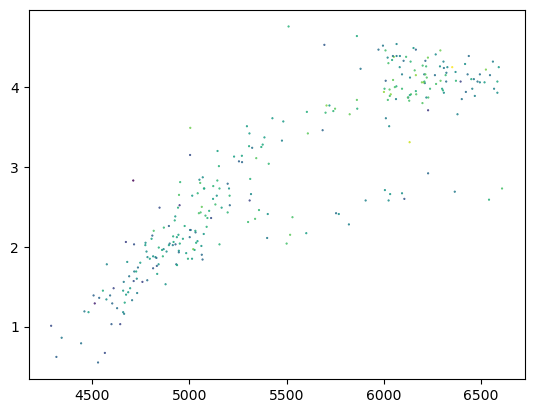

In [89]:
plt.scatter(ft_table['teff'],ft_table['logg'],c=ft_table['fe_h'],s=0.3)

In [90]:
ft_set

source_id         teff     e_teff      logg    e_logg  \
0        2745049530295263232  4486.255371  68.002647  4.657445  0.100572   
1        4922452332795612416  4900.511719  72.155556  4.464450  0.102015   
2        4919409709243747968  5543.346191  73.427536  4.175371  0.102718   
3        4685221429109310080  5529.029297  68.877304  4.521021  0.104782   
4        4683766775225601664  4977.451172  74.996758  3.172151  0.113069   
...                      ...          ...        ...       ...       ...   
1467056  6379920759951899648  4487.380859  18.906090  1.060154  0.070980   
1467057  1998097371124974720  4859.908691   9.050734  2.480687  0.024013   
1467058  1994741318040223232  4585.409668  11.298859  2.571437  0.028686   
1467059  6379914575198998272  4509.591309  18.433924  1.334888  0.077052   
1467060  2772098031734496512  6281.626953  59.489235  3.972290  0.038770   

             fe_h    e_fe_h     alpha   e_alpha        age     e_age      W1  \
0       -0.396317  0.055118  0.153393  0.024897   3.215799  1.793265     NaN   
1       -1.032346  0.065797  0.231157  0.042733   0.017005  0.130402  11.589   
2       -0.654349  0.064612  0.292858  0.041623  13.842698  3.720578  11.803   
3        0.135527  0.056800 -0.009852  0.028337   3.414711  1.847894  10.633   
4       -0.612790  0.065126  0.292203  0.056503  10.581185  3.252873  10.843   
...           ...       ...       ...       ...        ...       ...     ...   
1467056 -1.278400  0.020432 -0.025169  0.024307   5.154208  2.491330  14.940   
1467057 -0.229250  0.006350  0.065434  0.006152   1.945970  0.720498  10.462   
1467058  0.119920  0.009225  0.037709  0.007182   2.361398  0.763392  10.994   
1467059 -1.041800  0.018825 -0.019310  0.023462   9.151896  0.968808  15.021   
1467060 -0.672220  0.008434  0.238005  0.014992   6.637845  3.325536  10.487   

             W2          G         BP         RP           bp_1  \
0           NaN        NaN        NaN        NaN            NaN   
1        11.611  13.600912  14.048682  12.978907  464745.307410   
2        11.835  13.280836  13.597154  12.787919  497179.163727   
3        10.665  12.207837  12.582831  11.667729  491913.513358   
4        10.889  12.944366  13.427569  12.295570  459335.964422   
...         ...        ...        ...        ...            ...   
1467056  15.054  17.396803  17.998756  16.663797  426212.214151   
1467057  10.529  13.828720  14.730772  12.888657  346582.095593   
1467058  11.203  13.981819  14.711185  13.154364  397486.370958   
1467059  15.165  17.562771  18.184559  16.808504  418452.433510   
1467060  10.501  11.662208  11.914618  11.247172  510041.911009   

                  bp_2          bp_3         bp_4         bp_5         bp_6  \
0                  NaN           NaN          NaN          NaN          NaN   
1        -45230.418659  -8403.841114  1867.043248  -930.110770 -3820.129248   
2        -89026.225473   1019.368811  2152.576259 -1849.357944 -1212.715970   
3        -64128.449378  -8634.507072  5833.671329 -2770.435999 -4323.433358   
4        -33738.972648 -12738.898262  6044.675592 -4314.122586 -1389.673243   
...                ...           ...          ...          ...          ...   
1467056   -1322.018011 -18188.491072  4808.901890 -6012.681420  3625.902565   
1467057   43807.402131 -15154.962914 -4526.018463 -3347.843356  5451.772147   
1467058   27512.712262 -20679.717437  -855.414072 -2493.445197   979.538843   
1467059    4565.147208 -18939.972312  6732.922798 -5067.190021  3094.466160   
1467060 -116751.607601  11723.398408 -2696.176134  -983.803887  1383.346569   

                bp_7         bp_8         bp_9        bp_10        bp_11  \
0                NaN          NaN          NaN          NaN          NaN   
1       -2076.630945   671.645347 -1613.233751  -583.173389  -264.907822   
2       -2916.398146   116.486983 -1700.052917   301.323849  -498.713283   
3       -2328.726877  1376.272557 -1070.795475   -20.692233   388.820567   
4       -19

In [91]:
ft_table['spec_source'] = 'li_et_al_vmps'
ft_set2 = pd.concat([ft_set, ft_table], ignore_index=True)

In [92]:
ft_set2

source_id         teff     e_teff      logg    e_logg  \
0        2745049530295263232  4486.255371  68.002647  4.657445  0.100572   
1        4922452332795612416  4900.511719  72.155556  4.464450  0.102015   
2        4919409709243747968  5543.346191  73.427536  4.175371  0.102718   
3        4685221429109310080  5529.029297  68.877304  4.521021  0.104782   
4        4683766775225601664  4977.451172  74.996758  3.172151  0.113069   
...                      ...          ...        ...       ...       ...   
1467347  2660208219502547584  5035.000000  28.000000  2.050000  0.060000   
1467348  2821294236410574080  4736.000000  35.000000  1.740000  0.120000   
1467349  2866981452805072640  4864.000000  39.000000  1.880000  0.050000   
1467350  2868460399023553664  5064.000000  35.000000  2.500000  0.040000   
1467351  2746403063468526976  4611.000000  46.000000  1.480000  0.120000   

             fe_h    e_fe_h     alpha   e_alpha        age     e_age      W1  \
0       -0.396317  0.055118  0.153393  0.024897   3.215799  1.793265     NaN   
1       -1.032346  0.065797  0.231157  0.042733   0.017005  0.130402  11.589   
2       -0.654349  0.064612  0.292858  0.041623  13.842698  3.720578  11.803   
3        0.135527  0.056800 -0.009852  0.028337   3.414711  1.847894  10.633   
4       -0.612790  0.065126  0.292203  0.056503  10.581185  3.252873  10.843   
...           ...       ...       ...       ...        ...       ...     ...   
1467347 -2.430000  0.120000       NaN       NaN        NaN       NaN   9.960   
1467348 -3.220000  0.110000       NaN       NaN        NaN       NaN  12.068   
1467349 -2.360000  0.100000       NaN       NaN        NaN       NaN   8.710   
1467350 -2.010000  0.090000       NaN       NaN        NaN       NaN   9.774   
1467351 -3.700000  0.180000       NaN       NaN        NaN       NaN  10.627   

             W2          G         BP         RP           bp_1          bp_2  \
0           NaN        NaN        NaN        NaN            NaN           NaN   
1        11.611  13.600912  14.048682  12.978907  464745.307410 -45230.418659   
2        11.835  13.280836  13.597154  12.787919  497179.163727 -89026.225473   
3        10.665  12.207837  12.582831  11.667729  491913.513358 -64128.449378   
4        10.889  12.944366  13.427569  12.295570  459335.964422 -33738.972648   
...         ...        ...        ...        ...            ...           ...   
1467347   9.968  12.086527  12.563046  11.435070  451848.776568 -38549.742684   
1467348  12.161  14.463034  14.995966  13.763576  437799.328336 -23560.652967   
1467349   8.719  10.867290  11.351499  10.204917  450053.105501 -37031.003519   
1467350   9.785  11.889286  12.374171  11.229742  448743.577068 -38002.040355   
1467351  10.662  13.154490  13.761119  12.401095  420028.242727  -3486.085175   

                 bp_3         bp_4         bp_5         bp_6         bp_7  \
0                 NaN          NaN          NaN          NaN          NaN   
1        -8403.841114  1867.043248  -930.110770 -3820.129248 -2076.630945   
2         1019.368811  2152.576259 -1849.357944 -1212.715970 -2916.398146   
3        -8634.507072  5833.671329 -2770.435999 -4323.433358 -2328.726877   
4       -12738.898262  6044.675592 -4314.122586 -1389.673243 -1983.054784   
...               ...          ...          ...          ...          ...   
1467347  -5166.535403  1800.825251 -4695.754000  4304.110639 -1276.944639   
1467348  -6144.786974   888.954883 -5666.931339  5805.186653  -578.102954   
1467349  -3885.157657  2074.039094 -5063.361385  3154.836709 -1236.558716   
1467350  -4817.266997  1759.088982 -5064.191735  4341.764142 -1294.417790   
1467351  -9988.602295  1244.357158 -7179.778497  5657.061745 -1092.567685   

                bp_8         bp_9       bp_10       bp_11       bp_12  \
0                NaN          NaN         NaN         NaN         NaN   
1         671.645347 -1613.233751 -583.173389 -264.907822  258.211195   
2         116.486983 -1700.0

In [93]:
towrite = Table.from_pandas(ft_set2)
towrite.write('/arc/projects/k-pop/catalogues/andrae2023/ftset_spec_ga_0602_realmags.fits',overwrite=True,format='fits')

In [94]:
ft_set2.source_id.value_counts()

source_id
2558459589561967232    3
677825553901841024     2
5266300714372302336    2
3579083796370254592    2
2680527610995890560    2
                      ..
5789959344894958208    1
3612903610105230848    1
6064863326579995136    1
6287725369932977152    1
2746403063468526976    1
Name: count, Length: 1417678, dtype: int64

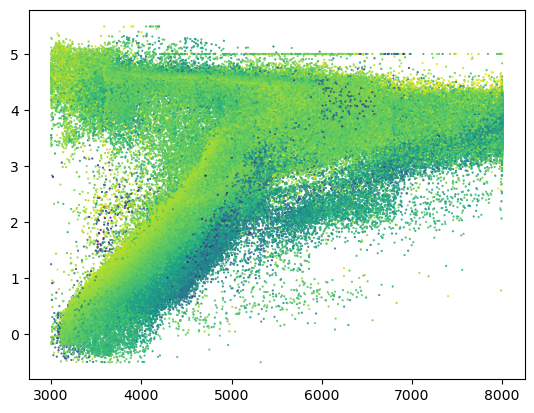

In [95]:
plt.scatter(ft_set2['teff'],ft_set2['logg'],c=ft_set2['fe_h'],s=0.3)

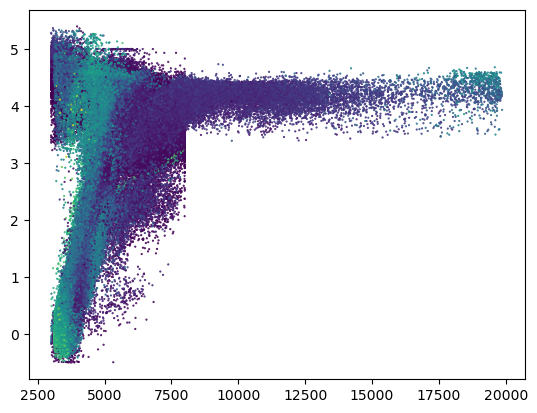

In [96]:
plt.scatter(ft_set2['teff'],ft_set2['logg'],c=ft_set2['age'],s=0.3)

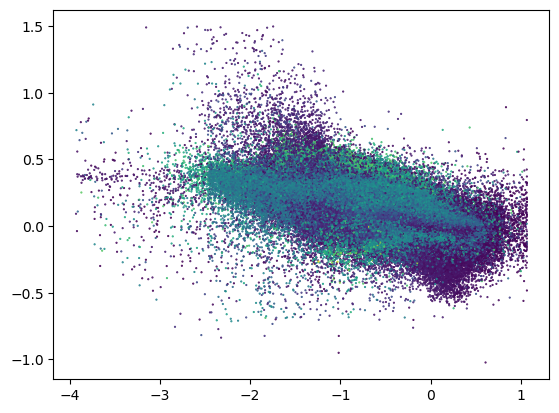

In [97]:
plt.scatter(ft_set2['fe_h'],ft_set2['alpha'],c=ft_set2['age'],s=0.3)

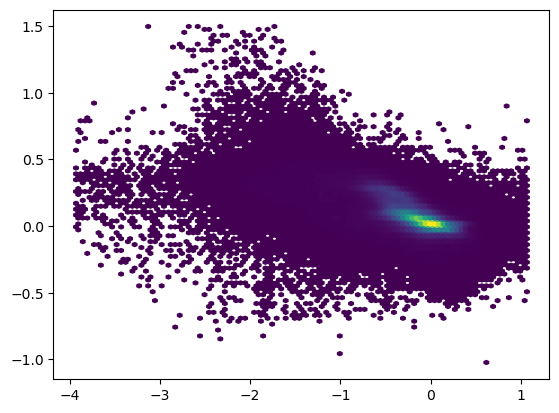

In [98]:
plt.hexbin(ft_set2['fe_h'],ft_set2['alpha'],mincnt=1,bins=400)

## Ensuring there are no NaNs

In [2]:
ft_set = Table.read('/arc/projects/k-pop/catalogues/andrae2023/ftset_spec_ga_0602_realmags.fits').to_pandas()

In [3]:
ft_set = ft_set.dropna(subset=['G'])

In [5]:
ft_set

source_id         teff     e_teff      logg    e_logg  \
1        4922452332795612416  4900.511719  72.155556  4.464450  0.102015   
2        4919409709243747968  5543.346191  73.427536  4.175371  0.102718   
3        4685221429109310080  5529.029297  68.877304  4.521021  0.104782   
4        4683766775225601664  4977.451172  74.996758  3.172151  0.113069   
5        4976477592542752384  5694.408691  68.380760  4.450530  0.094544   
...                      ...          ...        ...       ...       ...   
1467347  2660208219502547584  5035.000000  28.000000  2.050000  0.060000   
1467348  2821294236410574080  4736.000000  35.000000  1.740000  0.120000   
1467349  2866981452805072640  4864.000000  39.000000  1.880000  0.050000   
1467350  2868460399023553664  5064.000000  35.000000  2.500000  0.040000   
1467351  2746403063468526976  4611.000000  46.000000  1.480000  0.120000   

             fe_h    e_fe_h     alpha   e_alpha        age  ...       pmra  \
1       -1.032346  0.065797  0.231157  0.042733   0.017005  ...  48.081076   
2       -0.654349  0.064612  0.292858  0.041623  13.842698  ... -25.856214   
3        0.135527  0.056800 -0.009852  0.028337   3.414711  ...  36.991526   
4       -0.612790  0.065126  0.292203  0.056503  10.581185  ...  19.906693   
5        0.107221  0.055985 -0.002314  0.025627   4.739285  ... -13.233209   
...           ...       ...       ...       ...        ...  ...        ...   
1467347 -2.430000  0.120000       NaN       NaN        NaN  ...   7.871509   
1467348 -3.220000  0.110000       NaN       NaN        NaN  ...   3.246224   
1467349 -2.360000  0.100000       NaN       NaN        NaN  ...  12.530756   
1467350 -2.010000  0.090000       NaN       NaN        NaN  ...  11.361697   
1467351 -3.700000  0.180000       NaN       NaN        NaN  ...   3.343302   

             pmdec    e_pmra   e_pmdec  pmradec_corr  g_flux_error  \
1       -26.275559  0.018121  0.019242     -0.240860      8.874296   
2       -19.845870  0.026805  0.034231     -0.361083     25.730244   
3        -3.560709  0.010837  0.011559      0.007231     59.822346   
4        -6.288807  0.017682  0.016394     -0.011029     22.013437   
5       -17.704181  0.016248  0.021259     -0.320080     71.948509   
...            ...       ...       ...           ...           ...   
1467347  -5.787074  0.019304  0.012343     -0.044844     72.566360   
1467348   0.196585  0.025464  0.016026     -0.019815      6.843498   
1467349  -8.622131  0.019843  0.013190     -0.094139    119.320923   
1467350 -17.698827  0.014992  0.010419     -0.067467     71.869263   
1467351  -3.451063  0.021338  0.010874      0.009939     20.191229   

         bp_flux_error  rp_flux_error  e_parallax       spec_source  
1            21.170980      25.110329    0.019836          b'galah'  
2            21.331488      30.726351    0.028713          b'galah'  
3           103.126923     101.638260    0.010136          b'galah'  
4            43.652412      42.689857    0.014520          b'galah'  
5            73.069214      57.047688    0.025190          b'galah'  
...                ...            ...         ...               ...  
1467347     108.573586      78.593178    0.015708  b'li_et_al_vmps'  
1467348      17.676014      15.031563    0.020790  b'li_et_al_vmps'  
1467349     121.389618     158.698059    0.017005  b'li_et_al_vmps'  
1467350     103.345322     104.781082    0.014907  b'li_et_al_vmps'  
1467351      36.460598      46.388557    0.015822  b'li_et_al_vmps'  

[1345260 rows x 289 columns]

In [6]:
towrite = Table.from_pandas(ft_set)
towrite.write('/arc/projects/k-pop/catalogues/andrae2023/ftset_spec_ga_0602_realmags.fits',overwrite=True,format='fits')